# Um projeto de *machine learning*

## *California Housing*

Vamos trabalhar com um *dataset* de imóveis residenciais da Califórnia nos anos 1990.

### Obtendo os dados

In [1]:
from pathlib import Path

DATA_DIR = Path.cwd().parents[5] / 'datasets' / 'housing'
print(f'Saving data to {DATA_DIR}')

Saving data to /home/fjayres/dev/ml_labs/datasets/housing


In [2]:
import tarfile
from urllib import request


def fetch_housing_data(data_dir: Path) -> None:
    '''Downloads the California Housing Prices dataset.

    Downloads the California Housing Prices dataset from Aurelien Geron's
    GitHub repository and saves it to the specified directory.

    Args:
        data_dir: The directory to which the dataset will be saved.

    Returns:
        None
    '''
    if not data_dir.exists():
        data_dir.mkdir(parents=True)

    # Fetch the housing data.
    HOUSING_URL = ('https://raw.githubusercontent.com/ageron/handson-ml2/'
                   'master/datasets/housing/housing.tgz')
    tgz_path = data_dir / 'housing.tgz'
    request.urlretrieve(HOUSING_URL, tgz_path)

    # Extract the housing data.
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=data_dir, filter='data')

In [3]:
fetch_housing_data(DATA_DIR)

In [4]:
import pandas as pd


def load_housing_data(data_dir: Path) -> pd.DataFrame:
    '''Loads the California Housing Prices dataset.

    Loads the California Housing Prices dataset from the specified directory.

    Args:
        data_dir: The directory from which the dataset will be loaded.

    Returns:
        A pandas DataFrame containing the California Housing Prices dataset.
    '''
    csv_path = data_dir / 'housing.csv'
    df = pd.read_csv(csv_path)
    return df

In [5]:
data = load_housing_data(DATA_DIR)

print(f'O dataset tem {data.shape[0]} linhas e {data.shape[1]} colunas.')
print('As colunas são:')
for column_name in data.columns:
    print(f'- "{column_name}"')


O dataset tem 20640 linhas e 10 colunas.
As colunas são:
- "longitude"
- "latitude"
- "housing_median_age"
- "total_rooms"
- "total_bedrooms"
- "population"
- "households"
- "median_income"
- "median_house_value"
- "ocean_proximity"


### Entendimento do negócio

Esses dados representam informações censitárias acerca de *distritos* residenciais no estado da California na década de 1990.

Atividade: Baseado nos nomes das colunas, você conseguiria escrever o significado de cada coluna?

Resposta: não muito bem.

Consultando o livro-texto da disciplina, capítulo 2, aprendemos que esses dados se referem aos distritos (conforme escrito no enunciado) e, portanto, são um pouco estranhos. Provavelmente significam, para cada distrito, o seguinte:

- `longitude`: a longitude do centro;
- `latitude`: a latitude do centro;
- `housing_median_age`: a idade mediana dos imóveis;
- `total_rooms`: essa é estranha, é a quantidade **total** de cômodos no distrito. Ou seja, a soma do número de cômodos de todos os imóveis;
- `total_bedrooms`: a soma do número de *quartos* de todos os imóveis;
- `population`: quantas pessoas moram no distrito;
- `households`: número de imóveis;
- `median_income`: renda mediana dos moradores do distrito;
- `median_house_value`: o valor mediano dos imóveis do distrito. Esta é a nossa variável a ser predita;
- `ocean_proximity`: só pelo nome é difícil saber a natureza exata desta variável. Trata-se de uma variável *categórica* indicando o "status" do distrito em relação à sua proximidade com o oceano Pacífico.

Atividade: Escreva o objetivo de negócios deste projeto

Nosso objetivo é prever o valor mediano dos imóveis de um distrito residencial da Califórnia, baseado em uma série de atributos deste conforme visto acima.

### Análise exploratória

O objetivo da análise exploratória é "conhecer" os dados:

- Qual a distribuição de cada *feature*?

- Qual a natureza de cada *feature*?

    - Unidade de medida

    - Se é estritamente positiva ou se pode ser positiva ou negativa

    - Para que serve?

- Quais e como são as distribuições conjuntas de *features*? Em particular, como as *features* se relacionam com o *target*?

- Existem anomalias e erros?

    - Dados faltantes

    - "Saturação" de dados

    - Outliers

    - Desbalanceamento de classes

    - Dados duplicados

#### Análise exploratória: antes ou depois da separação treino-teste?

Durante o processo de modelagem vamos dividir os dados em dois conjuntos: "dados de treino" e "dados de teste". Devemos treinar nossos modelos com o conjunto de dados de treino, e avaliar seu desempenho no conjunto de teste, para que não nos enganemos com desempenhos preditivos excelentes no conjunto de treino e que não se reproduzem no conjunto de teste!

Atividade: Como se chama o fenômeno no qual temos um excelente desempenho no conjunto de treino e um desempenho bem menor no conjunto de teste?

<center>
<span style="color:red;font-family:Papyrus;font-weight:bold;font-size:30px">
    OVERFITTING!
</span>
<span style="color:darkgray;font-size:10px">
    booooooo!
</span>
</center>

Quando devemos fazer a análise exploratória?

- Antes da separação treino-teste, ou seja, no conjunto de dados completo?

- Depois da separação treino-teste, ou seja, usando apenas o conjunto de dados de treino?

Esta é uma pergunta difícil de responder.

- Analisar antes da separação:

    - Vantagens: todo o conjunto de dados de exemplo que foi coletado está á nossa disposição para estudo, o que torna mais fácil a detecção de anomalias raras, como outliers ou a ocorrência de categorias raras em *features* categóricas.

    - Desvantagens: corremos o risco de "data snooping" ("bisbilhotar" os dados), onde acabamos por aprender algo sobre os dados que pode impactar de modo "injusto" nossa modelagem - é como se estivéssemos "overfittando" sem querer!

- Analisar depois da separação:

    - Vantagens: reduz o risco de "data snooping"

    - Desvantagens: podemos não perceber anomalias e erros raros nos dados, que podem impactar nossa modelagem de uma forma que é difícil de identificar.

O que fazer então? Em geral, queremos balancear o risco de "data snooping" com o risco de não entender os detalhes mais finos e raros dos dados. Portando a recomendação é fazer análises exploratórias antes e depois da separação, com objetivos diferentes:

- Análise exploratória antes da separação: faça apenas análises globais e simples, para checar a sanidade dos dados e realizar filtragens simples. Evite análises que conectem as *features* com o *target*.

- Análise exploratória depois da separação: você está livre para explorar o que quiser.

Vamos fazer uma primeira análise dos dados, apenas para checar a integridade destes.

In [6]:
data.head(n=5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Atividade: Acompanhe o desenvolvimento da análise exploratória a ser feito pelo professor.

---

Nossa exploração terá três fases:

- Análise exploratória preliminar
- Separação treino-teste
- Análise exploratória complementar

É importante distinguir a análise exploratória realizada antes da separação de dados em conjuntos de treino e teste, daquela posterior a esta separação, para evitar o *"data snooping"* descrito acima.

#### Análise exploratória

Nesta fase vamos conhecer a natureza dos dados sem explorar suas interrelações, em especial não vamos explorar a conexão entre as *features* e o *target*.

Vamos proceder da seguinte forma:

<table>

<tr>
<th> Etapa </th>
<th> Objetivos </th>
<th> Ferramentas </th>
</tr>

<tr>

<td>
    Uma análise global do volume de dados
</td>

<td>
    <ul>
    <li> Quais são as <em>features</em>?</li>
    <li> Quem é o <em>target</em>?</li>
    <li> Quais variáveis são contínuas e quais são categóricas?</li>
    <li> Existem dados faltantes? </li>
    <li> Existem dados duplicados? </li>
    </ul>
</td>

<td>
    <div>
    <ul>
    <li> Número de linhas e colunas </li>
    <li> Tipo de dados de cada coluna </li>
    <li> Remoção de linhas duplicadas <em>se isso realmente for um erro</em> </li>
    </ul>
    </div>
</td>
</tr>

<tr>

<td>
    Uma primeira análise da natureza das features
</td>

<td>
    <ul>
    <li> Qual a unidade de medida de cada variável? </li>
    <li> Existem anomalias? 
        <ul>
            <li> <em>outliers</em> </li>
            <li> erros grosseiros </li>
            <li> <em>spikes</em> </li>
        </ul>
    </li>
    <li> Para cada variável contínua
        <ul>
            <li> Simétrica? </li>
            <li> Estritamente positiva/negativa? </li>
            <li> Unimodal / multimodal? </li>
            <li> Cauda longa à direita/esquerda? </li>
        </ul>
    </li>
    <li> Para cada variável categórica
        <ul>
            <li>Categorias raras?</li>
            <li>Categorias dominantes?</li>
        </ul>
    </li>
    </ul>
</td>

<td>
    <ul>
    <li>Medidas descritivas de posição e espalhamento</li>
    <li>Histogramas</li>
    <li>Tabelas de frequência</li>
    <li>Gráficos de barra</li>
    </ul>
</td>

</tr>

</table>

##### Análise global

Vamos conferir os tipos de dados espiando as primeiras linhas do *dataset*:

In [8]:
data.head(n=5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


E vamos verificar quantos exemplos temos, e qual o tipo de dados identificado pelo Pandas para cada coluna:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


As colunas do tipo `float64` são todas contínuas neste exemplo. Isso nem sempre é verdade: pode ser que tenhamos uma variável categórica que foi lida como `float64` por engano! Sempre verifique a natureza das suas variáveis.

Em teoria, não é estritamente correto dizer que essas variáveis `float64` são perfeitamente contínuas. Na verdade, a maioria delas é discreta, pois trata-se de contagens ou de idade inteira: `housing_median_age`, `total_rooms`, `total_bedrooms`, `population`, `households`. A decisão de convertê-las para inteiros ou mantê-las como números reais é dependente de aplicação. Para nós, neste projeto, não vai fazer diferença.

A feature `ocean_proximity` é do tipo `object`, que é o tipo de dados que o Pandas associa a qualquer coisa que não seja um número.


Vamos registrar as descrições e unidades de medida de cada variável:

| Variável             | Unidade de medida  | Descrição                                         |
|----------------------|--------------------|---------------------------------------------------|
| `longitude`          | graus              | a longitude do centro                             |
| `latitude`           | graus              | a latitude do centro                              |
| `housing_median_age` | anos               | a idade mediana dos imóveis                       |
| `total_rooms`        | n/a - contagem     | soma do número de cômodos de todos os imóveis     |
| `total_bedrooms`     | n/a - contagem     | a soma do número de *quartos* de todos os imóveis |
| `population`         | n/a - contagem     | quantas pessoas moram no distrito                 |
| `households`         | n/a - contagem     | número de imóveis                                 |
| `median_income`      | US$ $\times 10000$ | renda mediana dos moradores do distrito           |
| `median_house_value` | US$                | o valor mediano dos imóveis do distrito           |
| `ocean_proximity`    | n/a - categoria    | categoria de proximidade com o oceano Pacífico    |

As informações aqui foram obtidas do livro-texto da disciplina, capítulo 2, que está servindo de "Business Expert" para a gente.

In [10]:
data_no_dups = data.drop_duplicates()

In [11]:
data_no_dups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


O *dataset* sem linhas duplicadas tem o mesmo tamanho do *dataset* original, indicando que não existiam linhas duplicadas de qualquer forma.

##### Análise preliminar das features

Vamos verificar as medidas descritivas de cada feature, a começar pelas variáveis contínuas:

In [12]:
data.select_dtypes(include='number').describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Quando a tabela fica muito longa horizontalmente e curta verticalmente, tente "transpor" a tabela para ver se fica melhor:

In [13]:
data.select_dtypes(include='number').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


Melhorou. Agora limite o número de casas decimais para ficar mais fácil ainda de observar.

In [14]:
data.select_dtypes(include='number').describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.57,2.00,-124.35,-121.80,-118.49,-118.01,-114.31
latitude,20640.0,35.63,2.14,32.54,33.93,34.26,37.71,41.95
housing_median_age,20640.0,28.64,12.59,1.00,18.00,29.00,37.00,52.00
total_rooms,20640.0,2635.76,2181.62,2.00,1447.75,2127.00,3148.00,39320.00
total_bedrooms,20433.0,537.87,421.39,1.00,296.00,435.00,647.00,6445.00
population,20640.0,1425.48,1132.46,3.00,787.00,1166.00,1725.00,35682.00
households,20640.0,499.54,382.33,1.00,280.00,409.00,605.00,6082.00
median_income,20640.0,3.87,1.90,0.50,2.56,3.53,4.74,15.00
median_house_value,20640.0,206855.82,115395.62,14999.00,119600.00,179700.00,264725.00,500001.00


Observamos o seguinte:

- Todas as colunas possuem $20640$ itens não-nulos ("count"), exceto pela coluna `total_bedrooms` que tem valores faltantes. Vamos discutir medidas para lidar com isso em breve.

- Latitude e Longitude ficam em torno de $-120\degree$ e $36\degree$, correspondendo à localização geral da Califórnia.

<center>
<img 
    src="../../../../../../resources/california_location.png"
    alt="Snapshot of California showing latitude and longitude"
    width="400"
/>
</center>

- Fora latitude e longitude, as features são todas estritamente positivas, tem valor mínimo teórico de zero, e tem uma variabilidade muito alta! Podemos analisar a magnitude da variabilidade de cada feature em relação à sua própria média, obtendo desta forma um valor normalizado de variação chamado *coeficiente de variação*.

In [15]:
def compute_coefficient_of_variation(data: pd.DataFrame) -> pd.Series:
    '''Computes the coefficient of variation for each column in a DataFrame.

    Args:
        data: A pandas DataFrame.

    Returns:
        A pandas Series containing the coefficient of variation for each column
        in the input DataFrame.
    '''
    stats = data \
        .select_dtypes(include='number') \
        .describe() \
        .transpose() \
        .drop(['longitude', 'latitude'], axis=0)
    CV = stats['std'] / stats['mean']
    CV.rename('Coefficient of Variation', inplace=True)
    return CV


print(compute_coefficient_of_variation(data).round(2).to_markdown())

|                    |   Coefficient of Variation |
|:-------------------|---------------------------:|
| housing_median_age |                       0.44 |
| total_rooms        |                       0.83 |
| total_bedrooms     |                       0.78 |
| population         |                       0.79 |
| households         |                       0.77 |
| median_income      |                       0.49 |
| median_house_value |                       0.56 |


| Feature            |   Coefficient of Variation |
|:-------------------|---------------------------:|
| housing_median_age |                       0.44 |
| total_rooms        |                       0.83 |
| total_bedrooms     |                       0.78 |
| population         |                       0.79 |
| households         |                       0.77 |
| median_income      |                       0.49 |
| median_house_value |                       0.56 |

Podemos observar que as medidas de desvio padrão, quando normalizadas pelo valor da média (ou seja, o coeficiente de variação), são valores entre $44\%$ e $83\%$, indicando que existe muita diferença entre os distritos da Califórnia em todos esses atributos. 

E daí? Bem, esta observação pode indicar alternativas de modelagem dos dados. Talvez existam classes intrínsecas de distritos californianos, e que modelar essa possível *variável latente* pode ser útil para melhorar o desempenho do modelo. Talvez tenhamos *outliers* e cauda longa, que estão enviesando o cálculo do desvio padrão. De qualquer modo, indica que devemos prestar mais atenção na distribuição dos dados.

Vamos então estudar a distribuição de cada variável com histogramas:

In [16]:
import numpy as np

# Regra prática: número de bins = sqrt(número de amostras)
n_bins = np.floor(np.sqrt(data.shape[0])).astype(int).item()

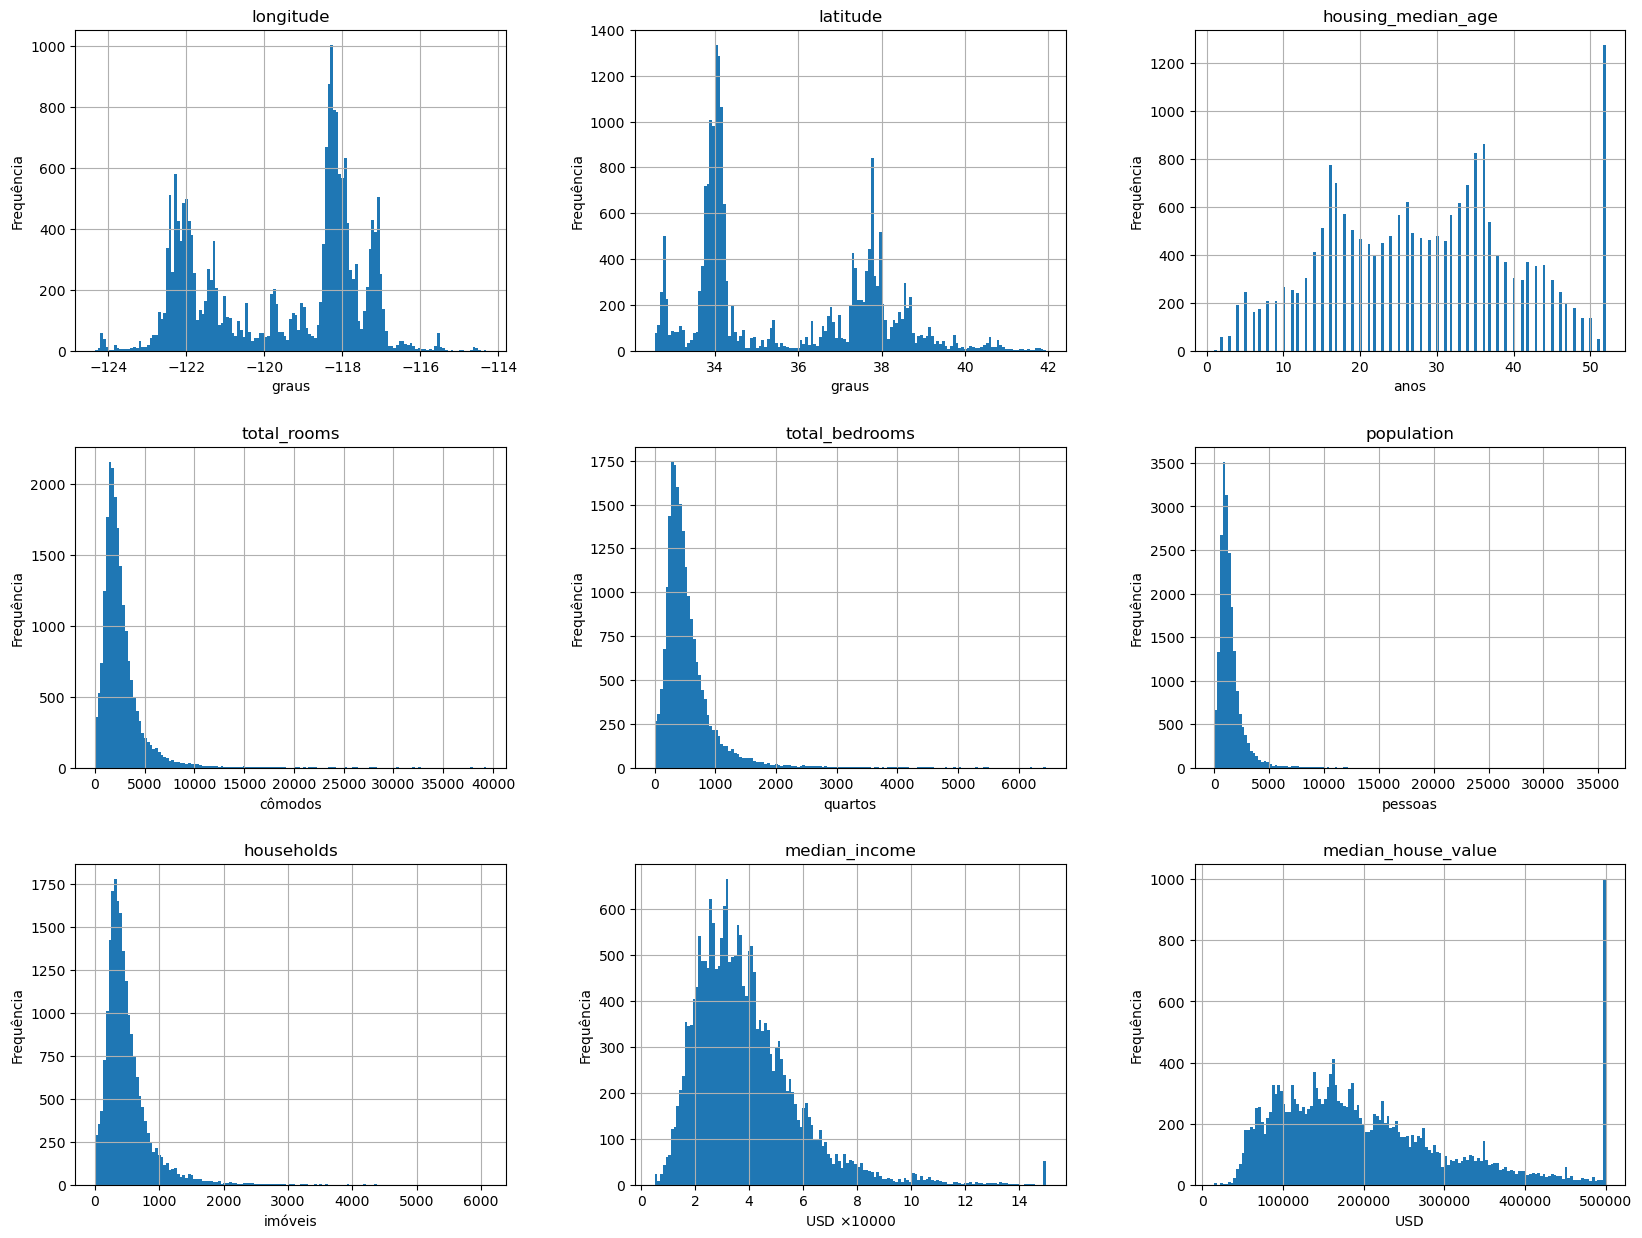

In [17]:
import matplotlib.pyplot as plt

measurement_units = {
    'longitude': 'graus',
    'latitude': 'graus',
    'housing_median_age': 'anos',
    'total_rooms': 'cômodos',
    'total_bedrooms': 'quartos',
    'population': 'pessoas',
    'households': 'imóveis',
    'median_income': r'USD $\times 10000$',
    'median_house_value': r'USD',
    'ocean_proximity': 'classe',
}

result = data \
    .select_dtypes(include='number') \
    .hist(bins=n_bins, figsize=(20, 15))

for subplot in result.flatten():
    column = subplot.get_title()
    if not column:
        continue
    unit = measurement_units[column]
    subplot.set_xlabel(unit)
    subplot.set_ylabel('Frequência')

plt.show()

Observamos o seguinte:

**Latitude e longitude**

Estão flutuando de um jeito dificil de entender. Mas isso é esperado - basta plotar os dados e compará-los á um mapa da California:

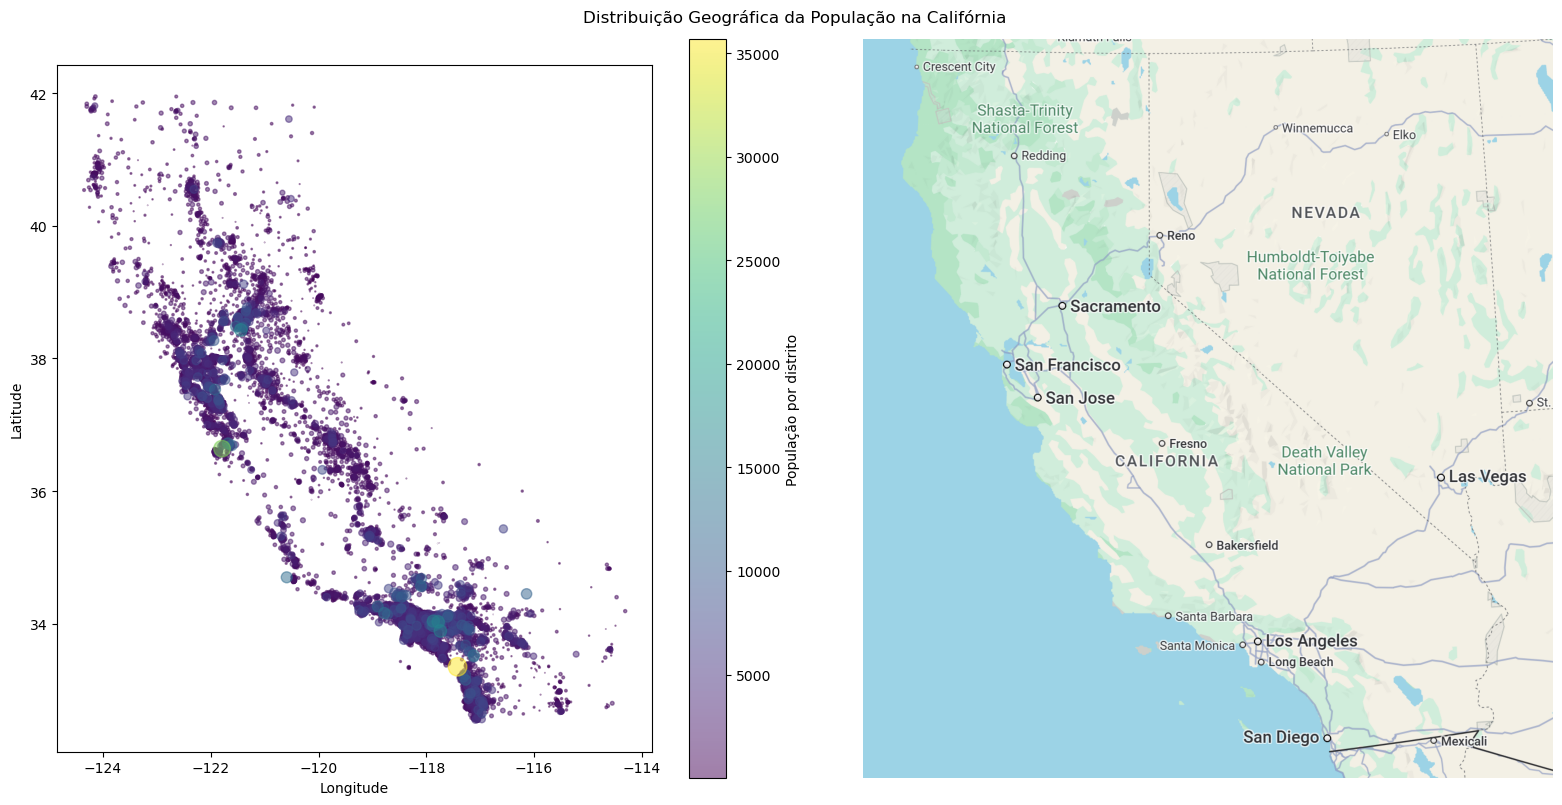

In [18]:
def plot_geo_pop():
    '''Plots the geographical distribution of the population in California.'''
    # Ordena os dados por população. É um truque para evitar que pontos
    # sobrepostos ocultem outros pontos. Assim, os pontos com populações
    # maiores são plotados por último.
    sorted_data = data.sort_values(by='population', ascending=True)

    longitude = sorted_data['longitude']
    latitude = sorted_data['latitude']
    population = sorted_data['population']

    # Ajusta a razão de aspecto para compensar a distorção da projeção.
    aspect_ratio = 1 / np.cos(np.mean(latitude) * np.pi / 180)

    img = plt.imread(Path.cwd().parents[5] / 'resources' / 'california.png')

    n_rows, n_cols = 1, 2

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 8))

    ax = axes[0]
    sct = ax.scatter(
        longitude,
        latitude,
        alpha=0.5,
        s=population / 200,
        c=population,
        cmap='viridis',
    )
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect(aspect_ratio)

    ax = axes[1]
    ax.imshow(img)
    ax.axis('off')

    fig.suptitle('Distribuição Geográfica da População na Califórnia')
    fig.colorbar(
        sct,
        ax=axes[0],
        orientation='vertical',
        label='População por distrito',
    )
    fig.tight_layout()


plot_geo_pop()

Aparentemente a população californiana se distribui heterogeneamente, como se espera de qualquer população.

***Spikes***

As colunas `house_median_age`, `median_house_value` e `median_income` possuem **spikes** em seus histogramas: barras finas e proeminentes no gráfico. Isso indica um excesso de elementos no *dataset* que apresentam o valor do *spike*, e requer investigação quanto á suas causas.



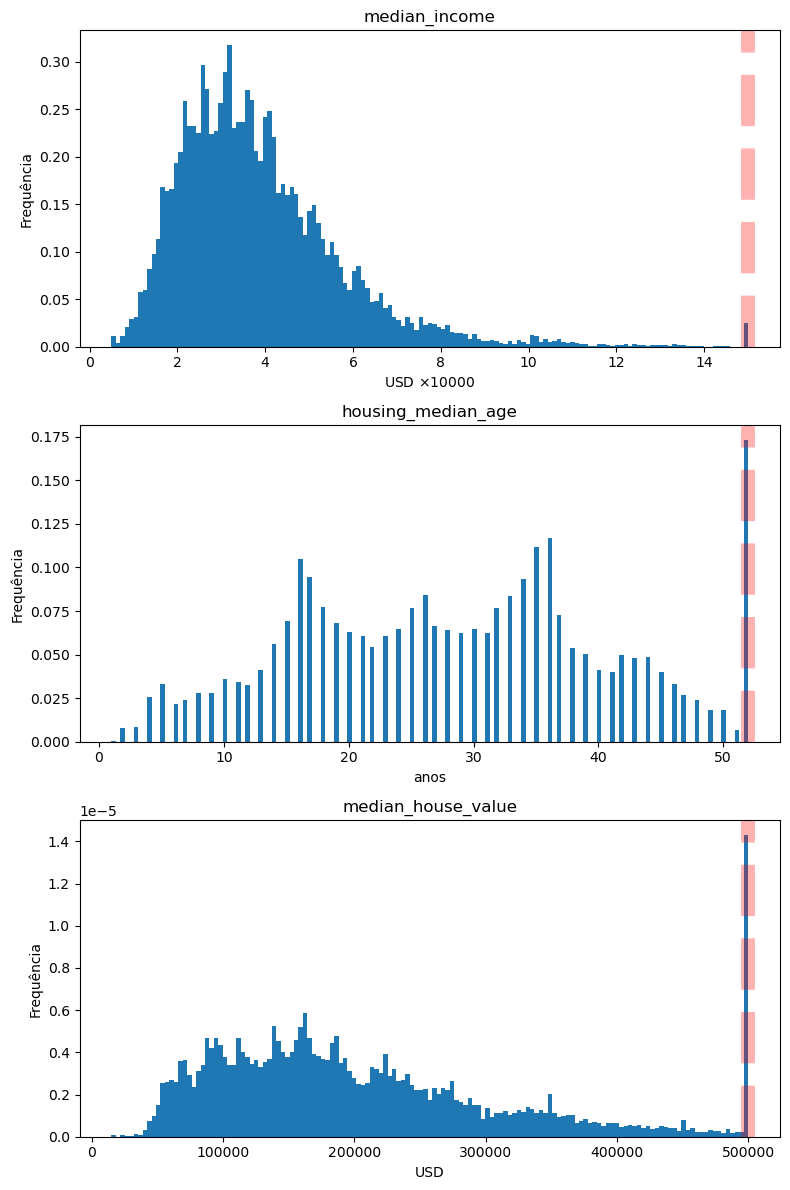

In [19]:
columns = [
    'median_income',
    'housing_median_age',
    'median_house_value',
]

spike_locations = {
    'median_income': 15,
    'housing_median_age': 52,
    'median_house_value': 500001,
}

fig, axes = plt.subplots(3, 1)
fig.set_size_inches(8, 12)
for ax, column in zip(axes, columns):
    ax.hist(data[column], bins=n_bins, density=True)
    ax.axvline(
        spike_locations[column],
        color='red',
        linestyle='--',
        linewidth=10,
        alpha=0.3,
    )
    ax.set_xlabel(measurement_units[column])
    ax.set_ylabel('Frequência')
    ax.set_title(column)
fig.tight_layout()
plt.show()

Neste caso, como os *spikes* estão localizados no extremo direito do histograma, provavelmente são devidos a um efeito de *saturação*. Por exemplo, pode ter sido o caso que a variável `median_house_value` registrou todos os preços de imóveis corretamente, exceto para imóveis que valiam mais do que USD $500$ mil - situação na qual o valor registrado é simplesmente $500001$.

O que fazer nesse caso? Posto que trata-se de dados inválidos, o melhor pode ser simplesmente ignorar esses exemplos - ou seja, removê-los do dataset.

**Colunas positivas com cauda à direita**

As colunas `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income` e `median_house_value` apresentam um comportamento comum:

- São quantidades estritamente positivas;
- Possuem cauda longa à direita.

Nestes casos, pode ser interessante aplicar uma transformação do tipo "logaritmo" aos dados. Vejamos como fica:

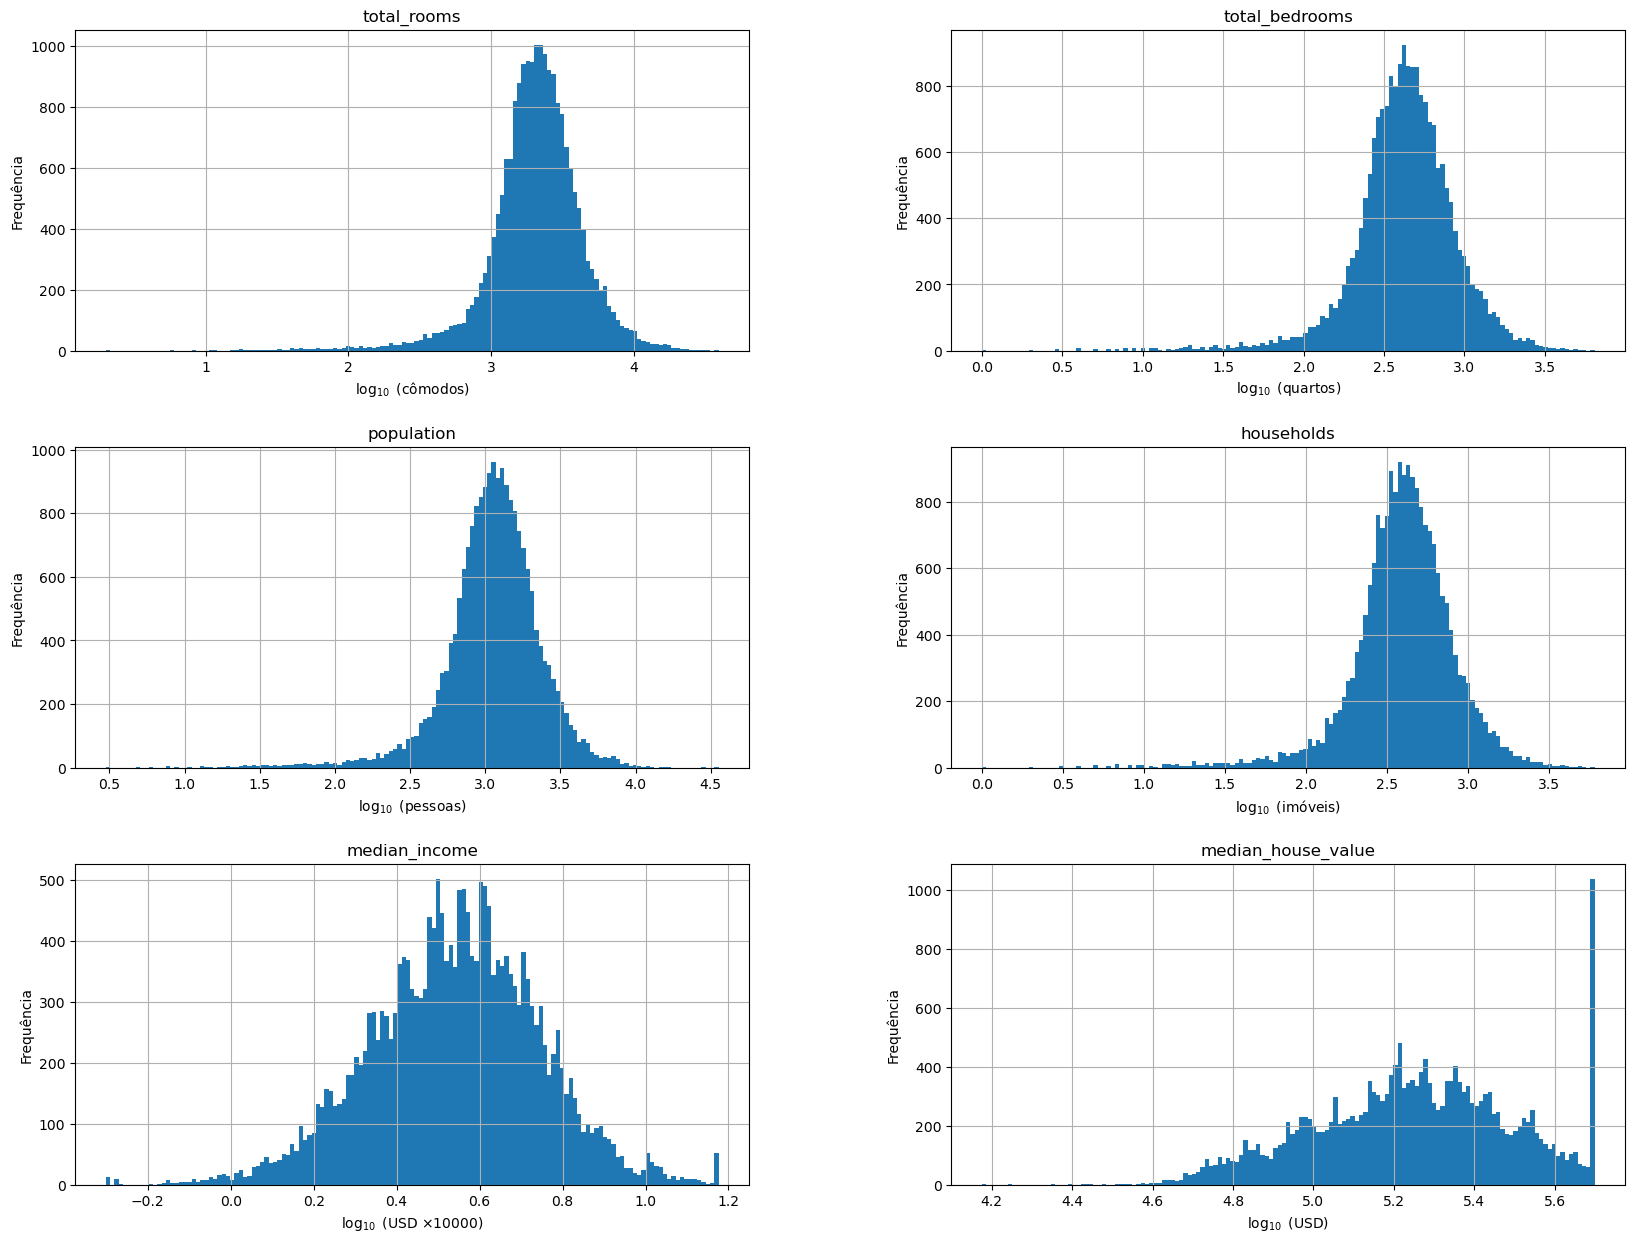

In [20]:
columns = [
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
]

results = data[columns] \
    .map(np.log10) \
    .hist(bins=n_bins, figsize=(20, 15))

for subplot in results.flatten():
    column = subplot.get_title()
    if not column:
        continue
    unit = measurement_units[column]
    subplot.set_xlabel('$\\log_{10}$ ' + f'({unit})')
    subplot.set_ylabel('Frequência')

plt.show()

É interessante notar que os dados, após uma transformação logarítmica, passam a ter uma característica mais simétrica, e sem *outliers*! Isso pode ser muito benéfico para alguns tipos de modelos, em especial o *modelo linear* que veremos em breve.

Vamos agora analisar a única *feature* categórica:

**`ocean_proximity`**

In [21]:
counts = data['ocean_proximity'].value_counts()

counts

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

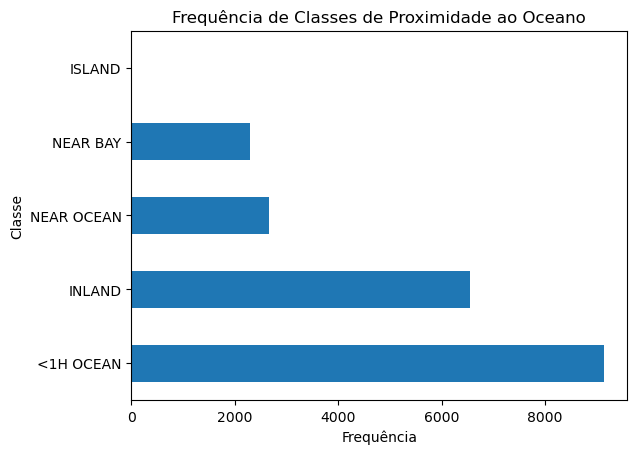

In [22]:
counts.plot.barh()
plt.xlabel('Frequência')
plt.ylabel('Classe')
plt.title('Frequência de Classes de Proximidade ao Oceano')
plt.show()


Temos uma classe com pouquíssima representação: `ISLAND`. Temos que decidir o que fazer: remover esses casos ou não? Para simplificar a análise, vamos remover esses casos.

### Filtragem

Atividade: Baseado no que aprendemos na análise exploratória, escreva um código para filtrar o *dataset*. Não modifique as colunas, apenas aceite ou rejeite cada linha de dados.

In [23]:
def get_valid_rows(data: pd.DataFrame) -> pd.Series:
    '''Returns a boolean Series indicating which rows of a DataFrame are valid.

    Args:
        data: A pandas DataFrame.

    Returns:
        A boolean Series indicating which rows of the input DataFrame are valid.
    '''
    # Remove rows with spikes.
    valid_rows = ((data['median_income'] < 15) &
                  (data['housing_median_age'] < 52) &
                  (data['median_house_value'] < 500001))

    # Remove rows with ocean_proximity == 'ISLAND'.
    valid_rows &= data['ocean_proximity'] != 'ISLAND'

    return valid_rows


def filter_data(data: pd.DataFrame) -> pd.DataFrame:
    '''Filters a DataFrame to remove invalid rows.

    Args:
        data: A pandas DataFrame.

    Returns:
        A pandas DataFrame with invalid rows removed.
    '''
    valid_rows = get_valid_rows(data)
    return data[valid_rows]


filtered_data = filter_data(data)

## Separação treino-teste

Antes de prosseguir com nossa análise exploratória, é melhor realizar a *separação treino-teste*, na qual vamos reservar uma porção dos nossos dados de exemplo para *treinar* nossos modelos, e outra parcela para *testar* o modelo escolhido e ter uma melhor noção acerca do real desempenho deste. 

Por que avaliar em um conjunto de dados diferente daquele de treino? Bem, em primeiro lugar, devemos lembrar que ambos os conjuntos de dados (treino e teste) vieram do mesmo conjunto de exemplos, e portanto são amostras da mesma população. Logo, ao avaliar o desempenho do modelo escolhido em um conjunto de teste, estamos verificando o comportamento estimado do modelo na população em geral.

Mas o conjunto de treino também veio da população, por que ele não serve para fazer uma avaliação de desempenho final? Por causa do 

<center>
<span style="color:red;font-family:Papyrus;font-weight:bold;font-size:30px">
    OVERFITTING!
</span>
<span style="color:darkgray;font-size:10px">
    booooooo!
</span>
</center>

Pode ser que seu modelo tenha se ajustado a características irrelevantes dos dados ("ruído") ao invés de se concentrar no comportamento mais provável dos seus dados.

Em termos semi-matemáticos, a idéia é a seguinte:

- Seus dados observados são uma mistura de dados "reais" DETERMINÍSTICOS (entra um certo "$x$", sai sempre o mesmo "y") e ruído ALEATÓRIO (cada vez que mede dá diferente);

- Para a parte determinística, estamos supondo que *realmente* existe uma parte $y = f(x)$ nesse experimento;

<center><img src="../../../../../../resources/y_sinal.png" width=600/></center>

- Para a parte aleatória, estamos supondo que trata-se de valores obtidos de uma distribuição de média zero, e que são independentes entre observações.

<center><img src="../../../../../../resources/y_ruido.png" width=600/></center>

- Os valores observados são, portanto, uma combinação do valor "real" (que só a fada dos sinais conhece) e do "ruído" (também, só de conhecimento do coelhinho da Páscoa dos ruídos), gerando o valor observado por nós.

<center><img src="../../../../../../resources/y_observado.png" width=600/></center>

- Entre duas amostras separadas de observações da população (o "conjunto de treino" e o "conjunto de teste") temos a repetição do comportamento da parte DETERMINÍSTICA, no sentido de que a regra de geração de valores $y$ a partir de $x$ (ou seja, a componente "escondida" $y = f(x)$ está firme e forte), e a parte ALEATÓRIA é a imprevisível.

<center><img src="../../../../../../resources/y_treino_teste.png" width=600/></center>

Ao treinar com

<center>
<span style="color:red;font-family:Papyrus;font-weight:bold;font-size:30px">
    OVERFITTING!
</span>
<span style="color:darkgray;font-size:10px">
    booooooo!
</span>
</center>

a gente acaba aprendendo um $y = g(x)$ onde $g(x)$ incorpora o $f(x)$ (alegria!) e também um extra ali que é só o ruido OBSERVADO NAQUELE CONJUNTO DE TREINO ESPECÌFICO! O modelo não sabe disso, tudo que ele observa é o conjunto de treino, sem saber o que é que daquilo ali é ruido!

<center><img src="../../../../../../resources/erro_overfitting.png" width=600/></center>



In [24]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    filtered_data,
    test_size=0.2,
    random_state=42,
    stratify=filtered_data['ocean_proximity'],
)

Agora podemos prosseguir com a análise exploratória.

## Análise exploratória pós-separação treino-teste

In [25]:
def split_features_target(
    train_data: pd.DataFrame, test_data: pd.DataFrame
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    '''Splits the features and target from the training and test sets.

    Args:
        train_data: The training set.
        test_data: The test set.

    Returns:
        A tuple containing the features and target for the training set, followed
        by the features and target for the test set.
    '''
    X_train = train_data.drop('median_house_value', axis=1).copy()
    y_train = train_data['median_house_value'].copy()

    X_test = test_data.drop('median_house_value', axis=1).copy()
    y_test = test_data['median_house_value'].copy()

    return X_train, y_train, X_test, y_test

In [26]:
X_train, y_train, X_test, y_test = split_features_target(train_data, test_data)

### Análise de correlações

#### Correlações entre features

**Correlações entre features contínuas**

Vamos verificar como as *features* contínuas se inter-relacionam usando diagramas de espalhamento e métricas de correlação.

In [27]:
corr_matrix = X_train.select_dtypes(include='number').corr()

In [28]:
corr_matrix.round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,1.00,-0.92,-0.04,0.03,0.06,0.09,0.05,-0.01
latitude,-0.92,1.00,-0.05,-0.02,-0.06,-0.10,-0.07,-0.08
housing_median_age,-0.04,-0.05,1.00,-0.38,-0.34,-0.29,-0.31,-0.20
total_rooms,0.03,-0.02,-0.38,1.00,0.93,0.86,0.92,0.22
total_bedrooms,0.06,-0.06,-0.34,0.93,1.00,0.88,0.98,0.02
population,0.09,-0.10,-0.29,0.86,0.88,1.00,0.91,0.04
households,0.05,-0.07,-0.31,0.92,0.98,0.91,1.00,0.04
median_income,-0.01,-0.08,-0.20,0.22,0.02,0.04,0.04,1.00


In [29]:
import seaborn as sns

<Axes: >

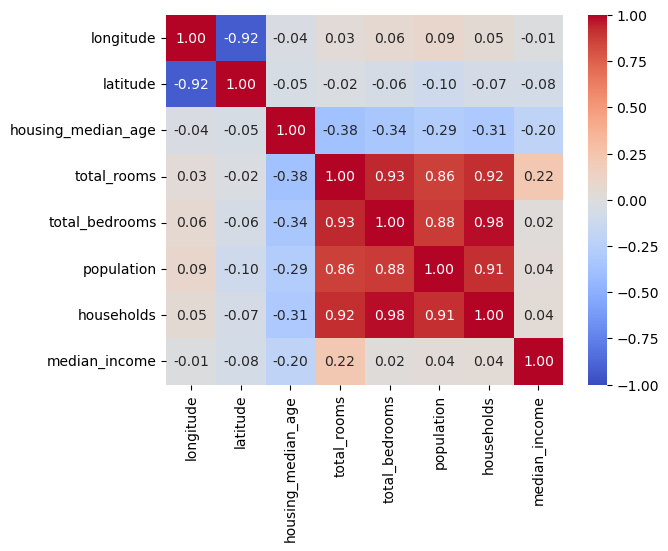

In [30]:
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1,
    vmax=1,
)

Aparentemente as colunas `total_rooms`, `total_bedrooms`, `population` e `households` são altamente correlacionadas, o que faz sentido: quanto mais imóveis, mais cômodos, quartos e gente. Geralmente não gostamos de *features* muito correlacionadas: isto pode ser um sinal de que a verdadeira informação está escondida por trás destas *features*, que são apenas o reflexo desta informação escondida.

Vamos ver o que acontece se dividimos `total_rooms`, `total_bedrooms` e `population` por `households`, gerando assim novas *features*. Vamos também remover as *features* `total_rooms`, `total_bedrooms` e `population`. Note que não estamos perdendo informação: com as novas *features* podemos reconstruir as antigas *features* quando quisermos:

In [31]:
X_train_new_features = X_train.copy()

X_train_new_features['rooms_per_household'] = \
    X_train['total_rooms'] / X_train['households']
X_train_new_features['bedrooms_per_household'] = \
    X_train['total_bedrooms'] / X_train['households']
X_train_new_features['population_per_household'] = \
    X_train['population'] / X_train['households']

X_train_new_features.drop(
    columns=['total_rooms', 'total_bedrooms', 'population'],
    inplace=True,
)

corr_matrix = X_train_new_features.select_dtypes(include='number').corr()

<Axes: >

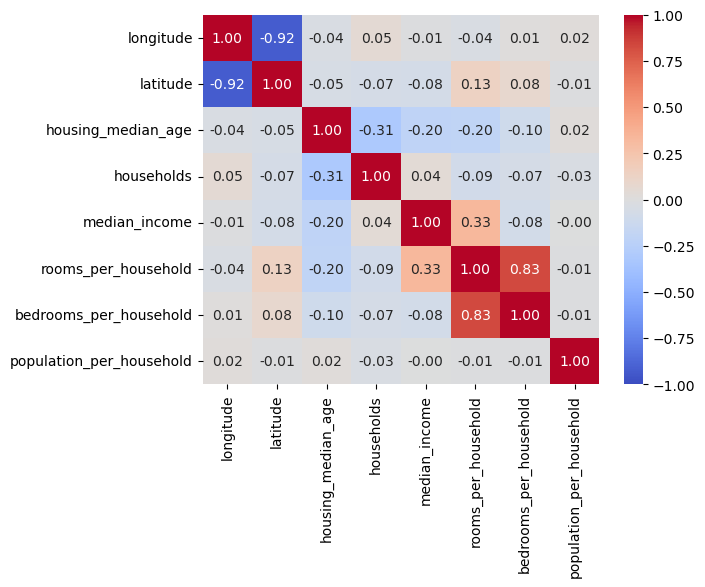

In [32]:
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1,
    vmax=1,
)

Parece que `rooms_per_household` e `bedrooms_per_household` ainda são muito correlacionadas, vamos criar `bedrooms_per_room` e ver o que acontece. Vamos também remover `bedrooms_per_household` (novamente, sem perda de informação: de `households`, `rooms_per_household` e `bedrooms_per_room` podemos recriar a informação removida).

In [33]:
X_train_new_features['bedrooms_per_room'] = \
    X_train['total_bedrooms'] / X_train['total_rooms']

X_train_new_features.drop(columns=['bedrooms_per_household'], inplace=True)

corr_matrix = X_train_new_features.select_dtypes(include='number').corr()

<Axes: >

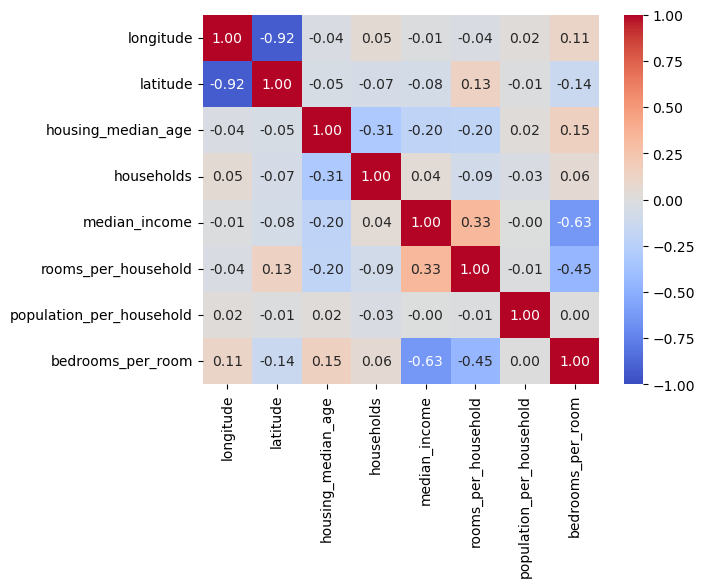

In [34]:
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1,
    vmax=1,
)

Por fim, as colunas `latitude` e `longitude` são altamente correlacionadas pois a California é um estado mais ou menos "esticado". Nada para se fazer por aqui que não seja mais sofisticado (e.g. análise de componentes principais) para o momento.

Vamos agora analisar os histogramas das features resultantes:

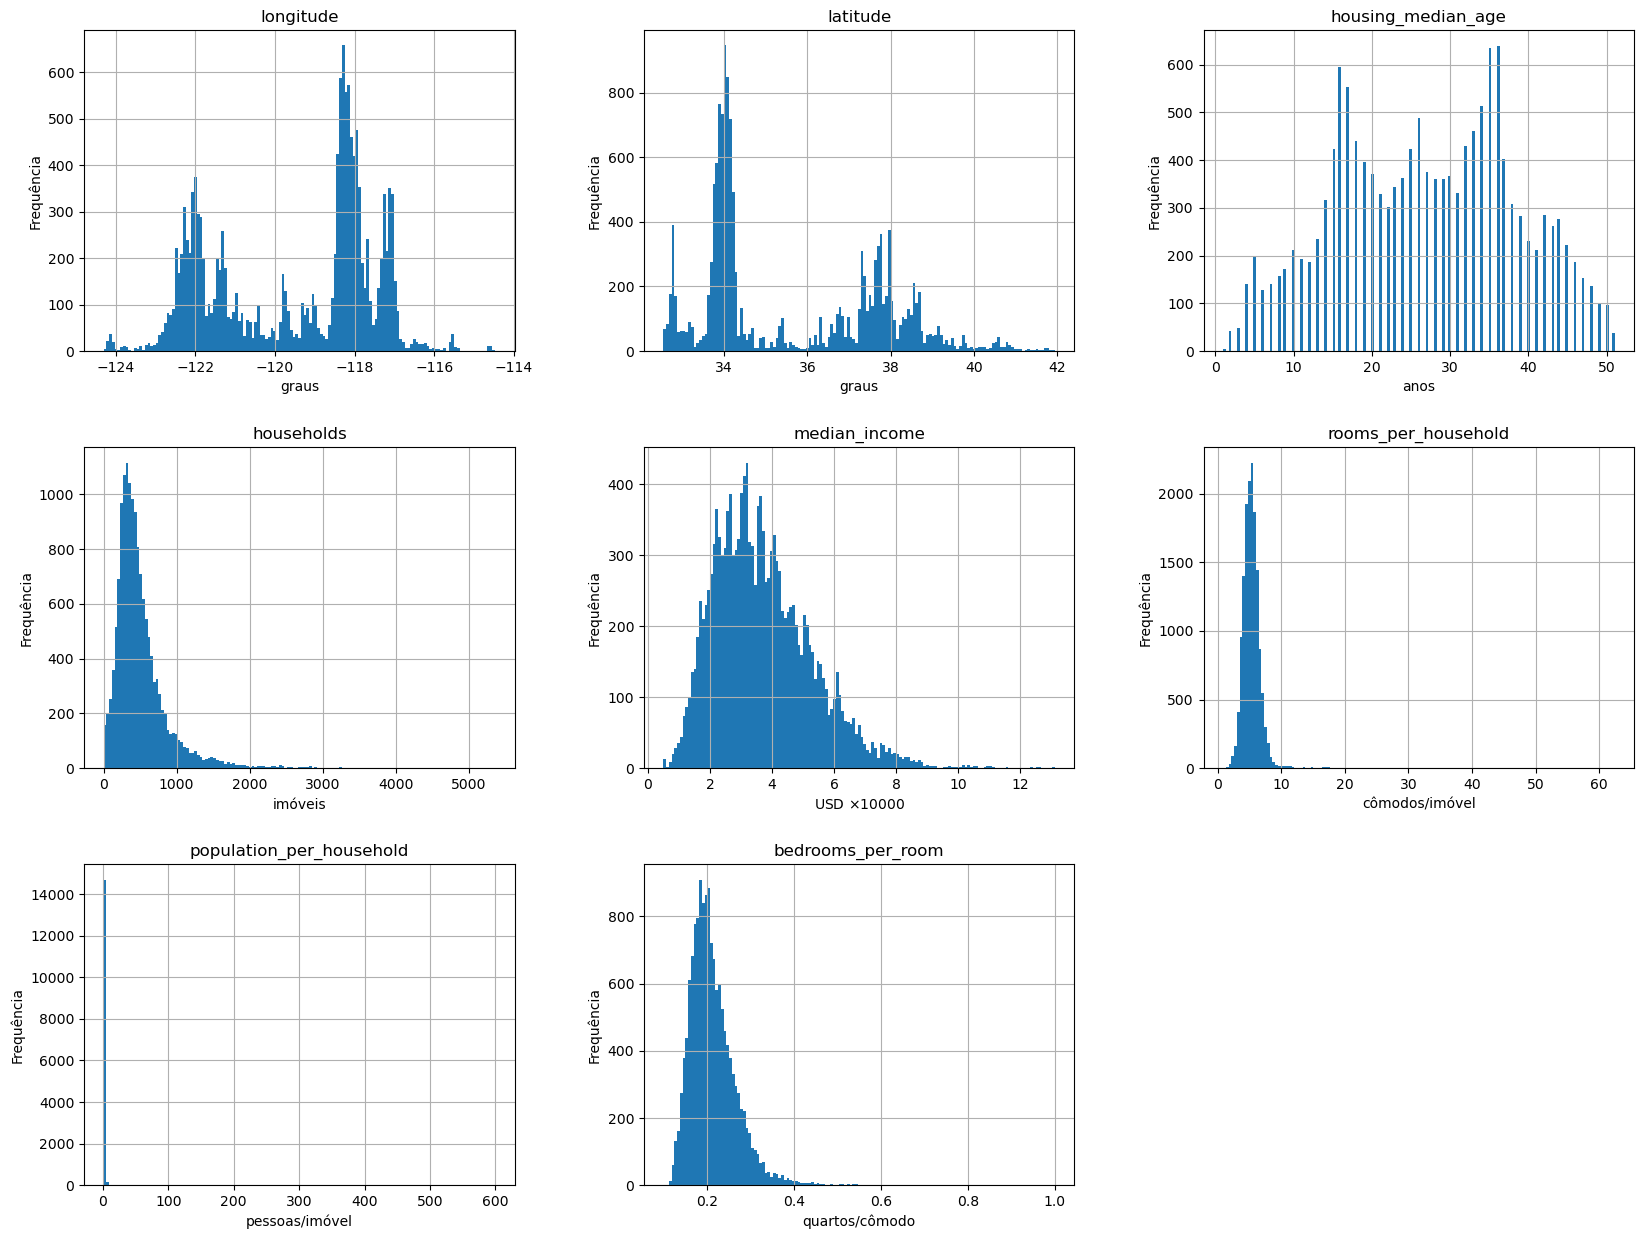

In [35]:
measurement_units = {
    'longitude': 'graus',
    'latitude': 'graus',
    'housing_median_age': 'anos',
    'households': 'imóveis',
    'median_income': r'USD $\times 10000$',
    'rooms_per_household': 'cômodos/imóvel',
    'population_per_household': 'pessoas/imóvel',
    'bedrooms_per_room': 'quartos/cômodo',
}

result = X_train_new_features \
    .select_dtypes(include='number') \
    .hist(bins=n_bins, figsize=(20, 15))

for subplot in result.flatten():
    column = subplot.get_title()
    if not column:
        continue

    unit = measurement_units[column]
    subplot.set_xlabel(unit)
    subplot.set_ylabel('Frequência')

plt.show()

In [36]:
X_train_new_features \
    .select_dtypes(include='number') \
    .describe() \
    .round(2) \
    .transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,14854.0,-119.49,1.99,-124.30,-121.56,-118.45,-117.97,-114.47
latitude,14854.0,35.60,2.16,32.54,33.92,34.24,37.68,41.95
housing_median_age,14854.0,26.93,11.45,1.00,17.00,27.00,36.00,51.00
households,14854.0,510.25,389.42,2.00,284.00,416.00,614.00,5358.00
median_income,14854.0,3.70,1.57,0.50,2.54,3.48,4.64,13.11
rooms_per_household,14854.0,5.40,2.20,0.85,4.44,5.22,6.01,62.42
population_per_household,14854.0,3.02,5.00,1.09,2.47,2.86,3.32,599.71
bedrooms_per_room,14698.0,0.21,0.06,0.10,0.18,0.20,0.24,1.00


Epa, tem coisa estranha aqui! Como assim temos distritos com 600 pessoas por imóvel! Ou 60 cômodos por imóvel! Algo está muito estranho!

Vamos ver o que anda acontecendo com a variável `population_per_household`:

In [37]:
X_train_new_features['population_per_household'].describe()

count    14854.000000
mean         3.018192
std          5.000398
min          1.089268
25%          2.472216
50%          2.857559
75%          3.320149
max        599.714286
Name: population_per_household, dtype: float64

In [38]:
X_train_new_features \
    .sort_values(by='population_per_household', ascending=False) \
    .head(n=20)

,longitude,latitude,housing_median_age,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
3364,-120.51,40.41,36.0,7.0,5.5179,INLAND,5.142857,599.714286,0.222222
12104,-117.33,33.97,8.0,20.0,1.6250,INLAND,7.600000,63.750000,0.125000
13366,-117.63,33.94,36.0,85.0,4.2578,INLAND,5.258824,33.952941,0.212528
14756,-116.97,32.56,23.0,275.0,2.5625,NEAR OCEAN,4.589091,18.821818,0.232964
4479,-118.16,34.07,41.0,50.0,3.5769,<1H OCEAN,4.940000,18.500000,0.222672
19435,-121.04,37.67,16.0,9.0,0.5360,INLAND,2.111111,18.444444,1.000000
1039,-120.97,38.42,16.0,287.0,4.3029,INLAND,6.090592,17.177700,0.184211
16672,-120.69,35.34,16.0,32.0,1.6563,NEAR OCEAN,5.125000,16.937500,0.182927
7164,-118.17,34.06,36.0,181.0,2.1845,<1H OCEAN,4.812155,15.812155,0.230769
2511,-119.54,36.51,36.0,2.0,4.6250,INLAND,24.500000,14.000000,0.142857


Vamos ver **onde** estes distritos estranhos estão - afinal temos a latitude e a longitude! Uma rápida consulta a uma aplicação de mapas revela o seguinte:

- $\text{latitude} = 40.41, \text{longitude} = -120.51$:

<center>
<img src="../../../../../../resources/pop_outlier_1.png" width=600 title="High Desert State Prison"/>
</center>

Parece que nesta "casa" tem muita gente mesmo. Melhor remover do conjunto de dados.

- $\text{latitude} = 33.97, \text{longitude} = -117.33$:

<center>
<img src="../../../../../../resources/pop_outlier_2.png" width=600 title="University of California, Riverside"/>
</center>

Aqui já não consigo explicar, mas parece ser um erro também. Os mais cínicos dirão que é do mesmo tipo da "casa" anterior, mas isso é veneno da língua só.

- $\text{latitude} = 33.94, \text{longitude} = -117.63$:

<center>
<img src="../../../../../../resources/pop_outlier_3.png" width=600 title="California Institution for Women, uma prisão feminina"/>
</center>

Mais uma prisão, melhor remover.

- $\text{latitude} = 32.56, \text{longitude} = -116.97$:

<center>
<img src="../../../../../../resources/pop_outlier_4.png" width=600 title="Southwestern College"/>
</center>

Novamente, o melhor que eu posso explicar aqui é a presença de uma instituição de ensino superior, de resto não faço idéia. Mas não parece ser um "típico" bairro residencial, podemos excluir da análise.

Em geral, parece que locais com número de imóveis muito reduzido são anômalos:

In [39]:
from matplotlib.text import Text
from typing import Iterable


def plot_scatter(
    df: pd.DataFrame,
    x: str,
    y: str,
    x_label: str,
    y_label: str,
    x_lim: tuple[float, float] | None,
    y_lim: tuple[float, float] | None,
    title: str,
    inches_per_col: float = 5,
    aspect_ratio: float = 4.0 / 3.0,
) -> None:
    '''Plots the population per household as a function of the number of households.'''

    def _set_endpoints(
        ticks: Iterable[float],
        endpoints: tuple[float | None, float | None],
    ) -> None:
        if endpoints[0] is not None:
            ticks[0] = endpoints[0]
        if endpoints[1] is not None:
            ticks[-1] = endpoints[1]
        return ticks

    def _set_endpoint_xticks(
        ax: plt.Axes,
        endpoints: tuple[float, float],
    ) -> None:
        ticks = ax.get_xticks()
        ticks = _set_endpoints(ticks, endpoints)
        ax.set_xticks(ticks)

    def _set_endpoint_yticks(
        ax: plt.Axes,
        endpoints: tuple[float, float],
    ) -> None:
        ticks = ax.get_yticks()
        ticks = _set_endpoints(ticks, endpoints)
        ax.set_yticks(ticks)

    def _plot_scatter(
        ax: plt.Axes,
        use_log: bool,
        x_lim: tuple[float, float] | None,
        y_lim: tuple[float, float] | None,
    ) -> None:
        df.plot.scatter(x=x, y=y, ax=ax, alpha=0.3)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if use_log:
            ax.set_xscale('log')
            ax.set_yscale('log')
        if x_lim is not None:
            _set_endpoint_xticks(ax, x_lim)
            ax.set_xlim(x_lim)
        if y_lim is not None:
            _set_endpoint_yticks(ax, y_lim)
            ax.set_ylim(y_lim)

    n_rows = 3
    n_cols = 2

    width = n_cols * inches_per_col
    height = n_rows * inches_per_col / aspect_ratio

    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(width, height),
    )

    fig.suptitle(title)
    fig.tight_layout(h_pad=4.0, w_pad=4.0)

    _plot_scatter(
        ax=axes[0, 0],
        use_log=False,
        x_lim=None,
        y_lim=None,
    )
    _plot_scatter(
        ax=axes[0, 1],
        use_log=True,
        x_lim=None,
        y_lim=None,
    )
    _plot_scatter(
        ax=axes[1, 0],
        use_log=False,
        x_lim=None,
        y_lim=y_lim,
    )
    _plot_scatter(
        ax=axes[1, 1],
        use_log=True,
        x_lim=None,
        y_lim=y_lim,
    )
    _plot_scatter(
        ax=axes[2, 0],
        use_log=False,
        x_lim=x_lim,
        y_lim=y_lim,
    )
    _plot_scatter(
        ax=axes[2, 1],
        use_log=True,
        x_lim=x_lim,
        y_lim=y_lim,
    )


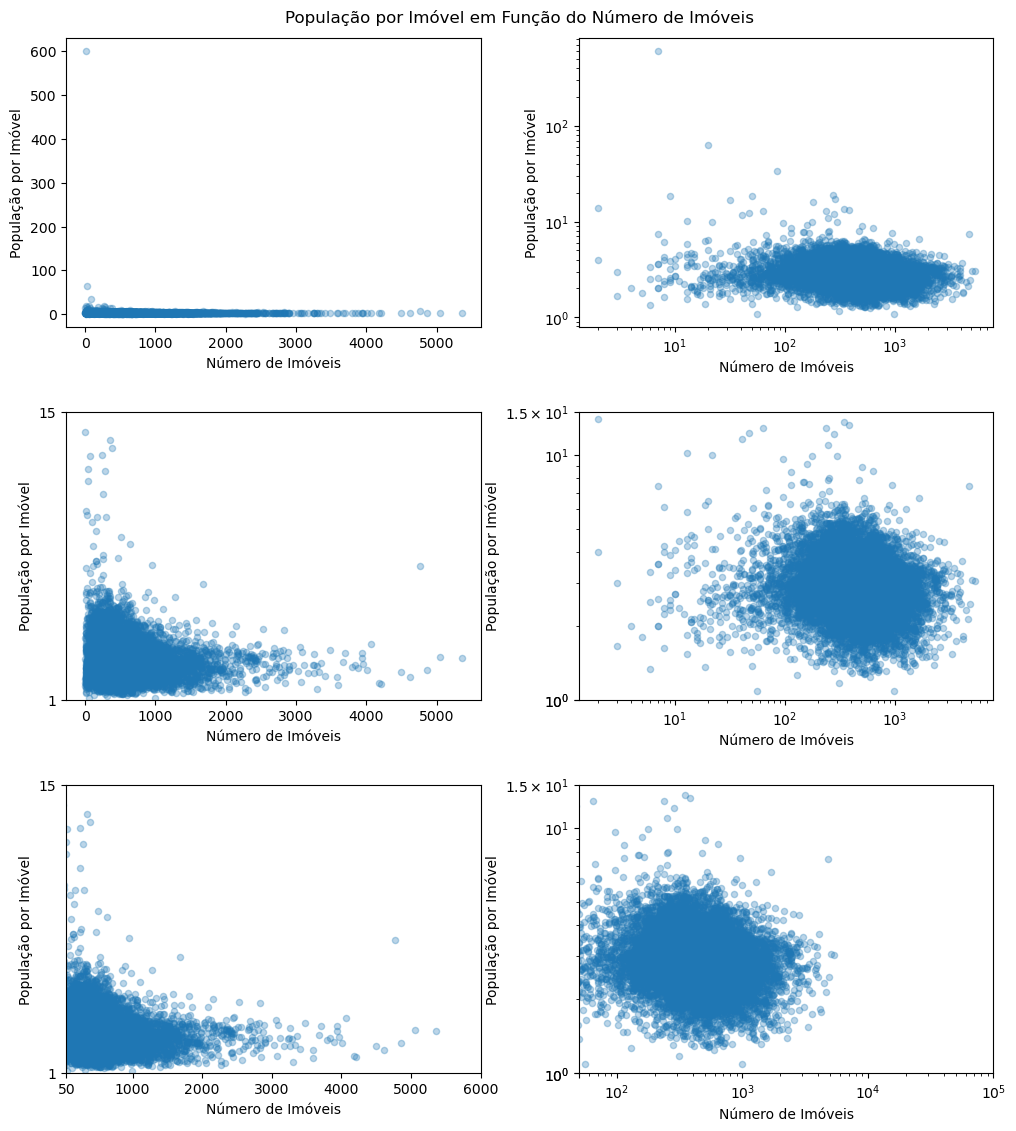

In [40]:
plot_scatter(
    df=X_train_new_features,
    x='households',
    y='population_per_household',
    x_label='Número de Imóveis',
    y_label='População por Imóvel',
    x_lim=(50, None),
    y_lim=(1, 15),
    title='População por Imóvel em Função do Número de Imóveis',
)

Observando o gráfico acima, podemos ver que:

- As anomalias de "população por imóvel" ocorrem para valores baixos de número de imóveis no distrito. 
- Ao utilizar a escala logarítmica para os gráficos de espalhamento, observamos que estes passam a se relacionar de forma mais "gaussiana", o que pode ser vantajoso para alguns modelos de machine learning. Quais modelos? Bem, é por isso que vamos aprender sobre os modelos em detalhe mais pra frente. Por enquanto, posso adiantar que modelos lineares podem se beneficiar de uma maior "normalidade" dos dados.

Vamos repetir esta análise para `households` e `rooms_per_household`:

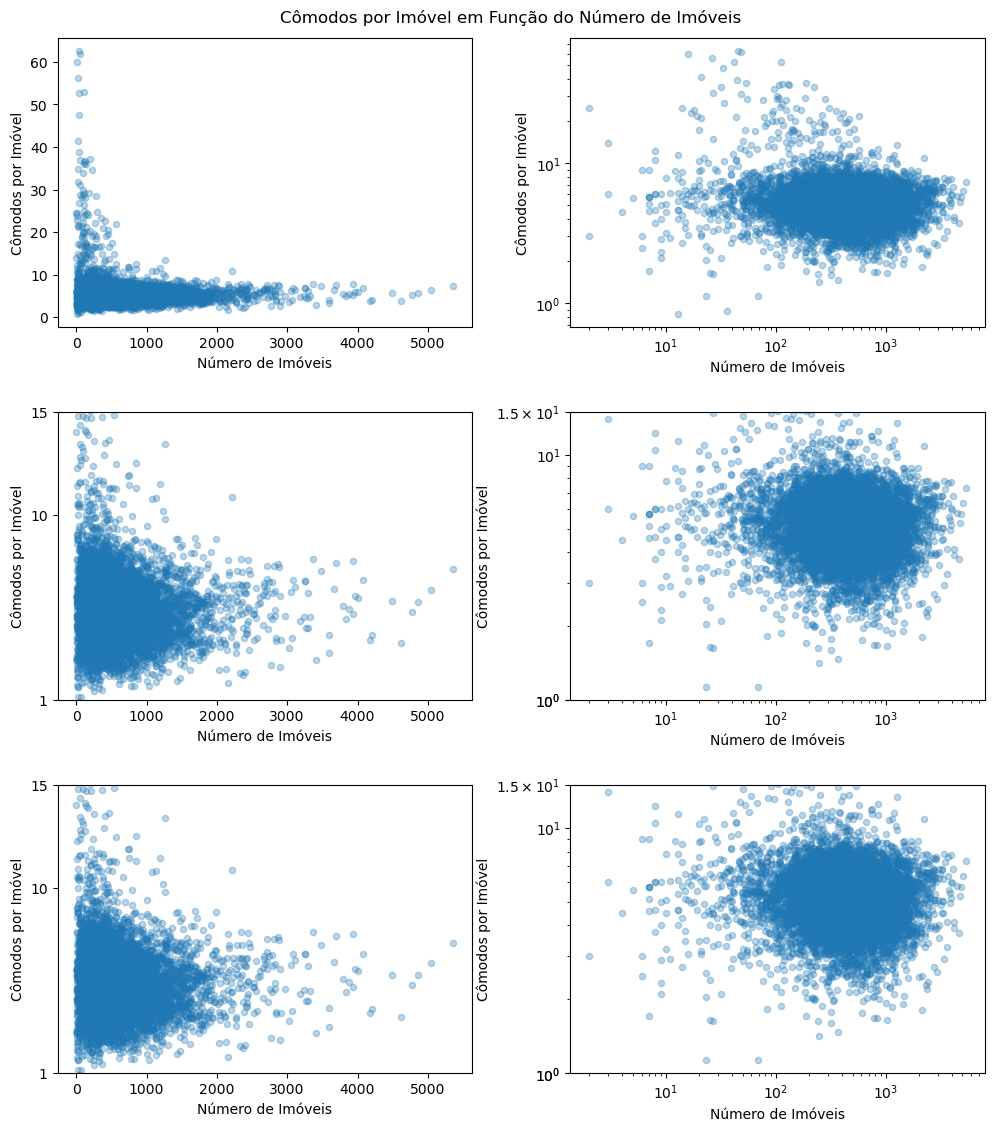

In [41]:
plot_scatter(
    df=X_train_new_features,
    x='households',
    y='rooms_per_household',
    x_label='Número de Imóveis',
    y_label='Cômodos por Imóvel',
    x_lim=None,
    y_lim=(1, 15),
    title='Cômodos por Imóvel em Função do Número de Imóveis',
)

Aqui temos esta anomalia de "cômodos por imóvel", mas é menos severa do que o caso de "população por imóvel". Ainda assim, observamos que acontece para distritos com baixo número de imóveis. Isto é mais uma evidência para cortar os distritos com poucos imóveis, embora seja difícil determinar um bom ponto de corte.

Vamos repetir a análise agora para as variáveis `households` e `bedrooms_per_room`:

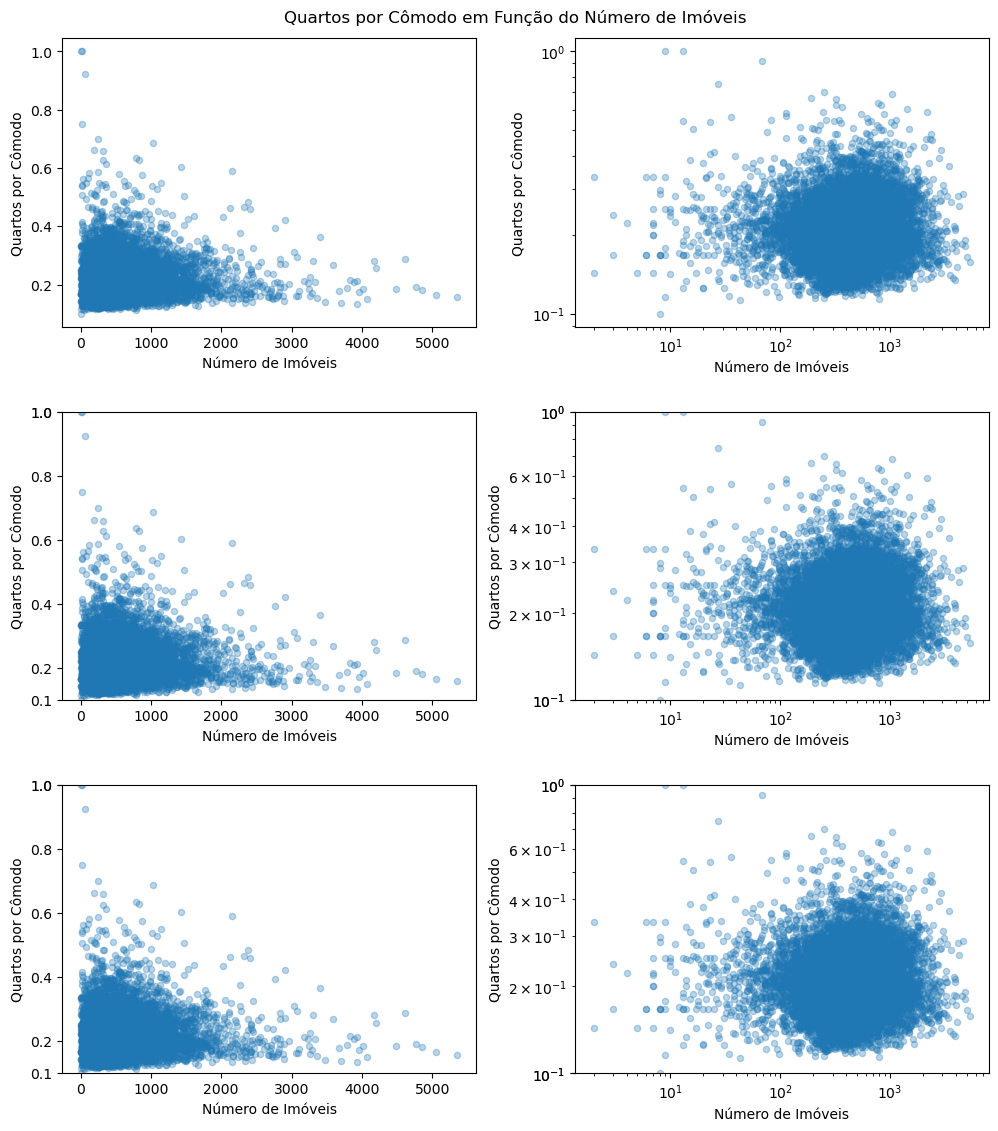

In [42]:
plot_scatter(
    df=X_train_new_features,
    x='households',
    y='bedrooms_per_room',
    x_label='Número de Imóveis',
    y_label='Quartos por Cômodo',
    x_lim=None,
    y_lim=(0.1, 1),
    title='Quartos por Cômodo em Função do Número de Imóveis',
)

Novamente, um pouco de *outliers* aqui para valores pequenos de número de imóveis no distrito. 

Com todas essas evidências de anomalias em distritos com poucos imóveis, vamos escolher um ponto de corte para eliminar esses distritos:

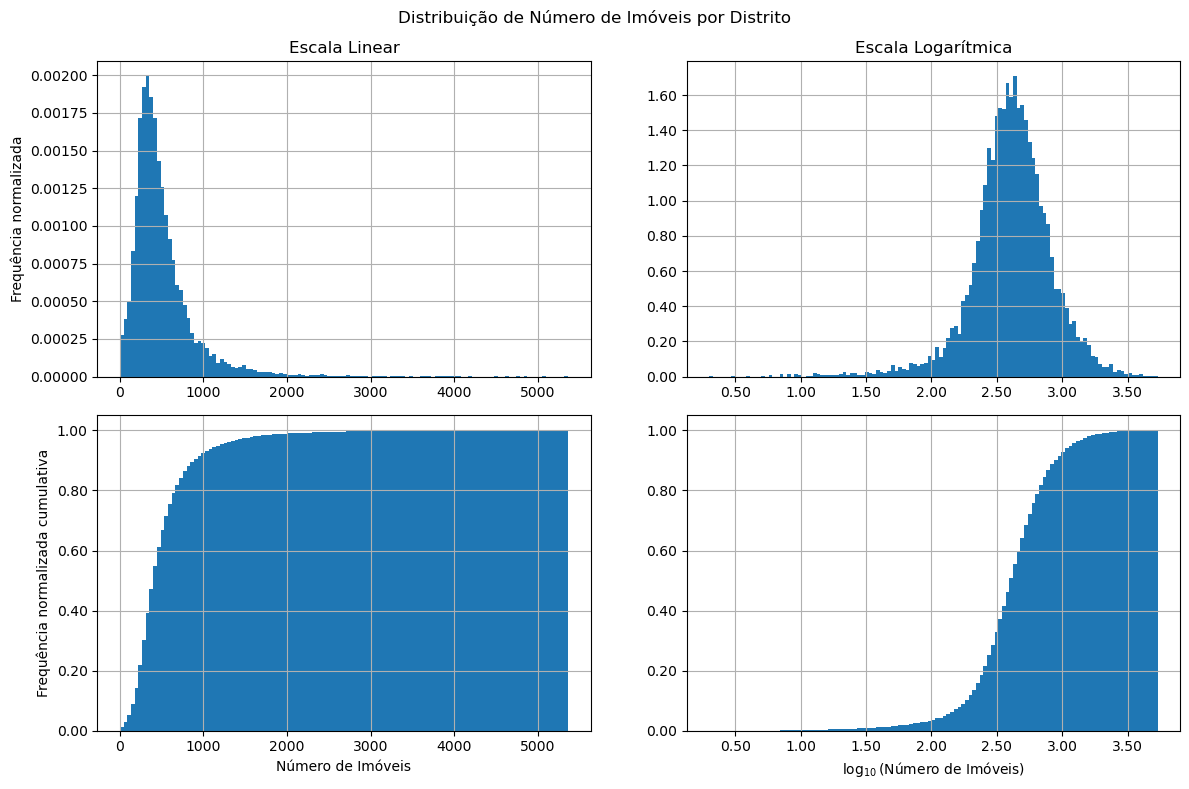

In [43]:
def plot_households(
    inches_per_col: float = 6.0,
    aspect_ratio: float = 1.5,
) -> None:
    '''Plots the distribution of the number of households.'''

    def _plot_households(
        ax: plt.Axes,
        feature: pd.Series,
        cumulative: bool,
        x_label: str | None,
        y_label: str | None,
        x_fmt: str | None,
        y_fmt: str | None,
        title: str | None,
    ) -> None:
        num_items = len(feature)
        n_bins = int(np.floor(np.sqrt(num_items)))

        ax.hist(feature, bins=n_bins, density=True, cumulative=cumulative)
        ax.grid(visible=True, which='both', axis='both')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if x_fmt is not None:
            ax.xaxis.set_major_formatter(x_fmt)
        if y_fmt is not None:
            ax.yaxis.set_major_formatter(y_fmt)
        ax.set_title(title)

    n_rows = 2
    n_cols = 2

    width = n_cols * inches_per_col
    height = n_rows * inches_per_col / aspect_ratio

    feature = X_train_new_features['households']
    log_feature = X_train_new_features['households'].map(np.log10)

    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(width, height),
    )

    fig.suptitle('Distribuição de Número de Imóveis por Distrito')

    _plot_households(
        ax=axes[0, 0],
        feature=feature,
        cumulative=False,
        x_label=None,
        y_label='Frequência normalizada',
        x_fmt='{x:.0f}',
        y_fmt=None,
        title='Escala Linear',
    )

    _plot_households(
        ax=axes[0, 1],
        feature=log_feature,
        cumulative=False,
        x_label=None,
        y_label=None,
        x_fmt='{x:.2f}',
        y_fmt='{x:.2f}',
        title='Escala Logarítmica',
    )

    _plot_households(
        ax=axes[1, 0],
        feature=feature,
        cumulative=True,
        x_label='Número de Imóveis',
        y_label='Frequência normalizada cumulativa',
        x_fmt='{x:.0f}',
        y_fmt='{x:.2f}',
        title=None,
    )

    _plot_households(
        ax=axes[1, 1],
        feature=log_feature,
        cumulative=True,
        x_label=r'$\log_{10}(\text{Número de Imóveis})$',
        y_label=None,
        x_fmt='{x:.2f}',
        y_fmt='{x:.2f}',
        title=None,
    )

    fig.tight_layout(w_pad=4.0)


plot_households()

Parece que, mais uma vez, a escala logarítmica é mais adequada para estes dados. Nesta escala, o ponto de corte $2.0$ parece bom no "olhômetro", vamos ver a qual percentil este ponto corresponde:

In [44]:
log_cut_point = 2.0

cut_point = 10**log_cut_point

values = X_train_new_features['households'].map(np.log10).values
quantile = (values < log_cut_point).mean().item()

print(f'quantile of {cut_point=:.2f} is {quantile=:.2%}')

quantile of cut_point=100.00 is quantile=3.29%


Ao cortar no valor $2.0$ na escala logarítmica, que corresponde a $100$ imóveis no distrito, estamos ignorando apenas $3.29\%$ dos dados. Isso parece ser uma perda aceitável mas, novamente, quem tem a última palavra é o *business expert*, ok?

In [45]:
good_rows = (X_train_new_features['households'] > cut_point)
X_train_new_features = X_train_new_features[good_rows]

Por fim, vamos analisar as demais colunas sobre o ponto de vista logaritmico, pois:

- São colunas de valor estritamente positivo;
- Possuem cauda longa à direita.

São situações que sugerem o uso da função $\log$ para "gaussianizar" os dados.

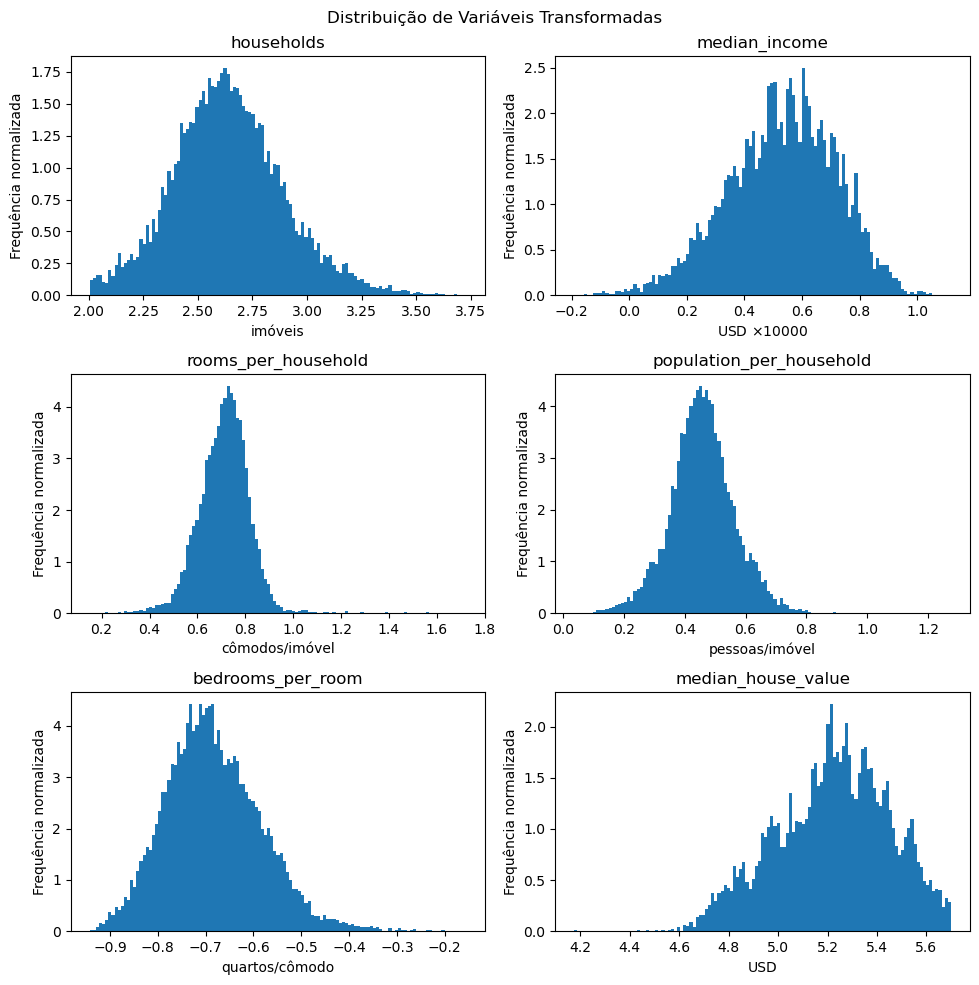

In [46]:
measurement_units = {
    'households': 'imóveis',
    'median_income': r'USD $\times 10000$',
    'rooms_per_household': 'cômodos/imóvel',
    'population_per_household': 'pessoas/imóvel',
    'bedrooms_per_room': 'quartos/cômodo',
    'median_house_value': r'USD',
}

columns = list(measurement_units.keys())

data_train_new_features = \
    pd.concat([X_train_new_features, y_train], axis=1)

data_train_new_features = data_train_new_features \
    .loc[:, columns] \
    .copy() \
    .map(np.log10)

num_items = data_train_new_features.shape[0]
n_bins = int(np.floor(np.sqrt(num_items)))

inches_per_column = 5
aspect_ratio = 1.5

n_cols = 2
n_rows = 3

width = n_cols * inches_per_column
height = n_rows * inches_per_column / aspect_ratio

fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(width, height))
fig.suptitle('Distribuição de Variáveis Transformadas')

for ax, column in zip(axes.flatten(), columns):
    ax.hist(data_train_new_features[column], bins=n_bins, density=True)
    ax.set_xlabel(measurement_units[column])
    ax.set_ylabel('Frequência normalizada')
    ax.set_title(column)

fig.tight_layout()

Parece ser uma boa idéia sim.

#### Correlações feature-target

In [47]:
measurement_units = {
    'longitude': 'graus',
    'latitude': 'graus',
    'housing_median_age': 'anos',
    'households': 'imóveis',
    'median_income': r'USD $\times 10000$',
    'rooms_per_household': 'cômodos/imóvel',
    'population_per_household': 'pessoas/imóvel',
    'bedrooms_per_room': 'quartos/cômodo',
    'median_house_value': r'USD',
    'ocean_proximity': 'classe',
}

num_features = [
    'longitude',
    'latitude',
    'housing_median_age',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
]

cat_features = [
    'ocean_proximity',
]

scale_features = [
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
]

target = 'median_house_value'

data_train_new_features = \
    pd.concat([X_train_new_features, y_train], axis=1) \
    .copy()

data_train_new_features[scale_features] = \
    data_train_new_features[scale_features].map(np.log10)
data_train_new_features[target] = \
    data_train_new_features[target].map(np.log10)

<Axes: >

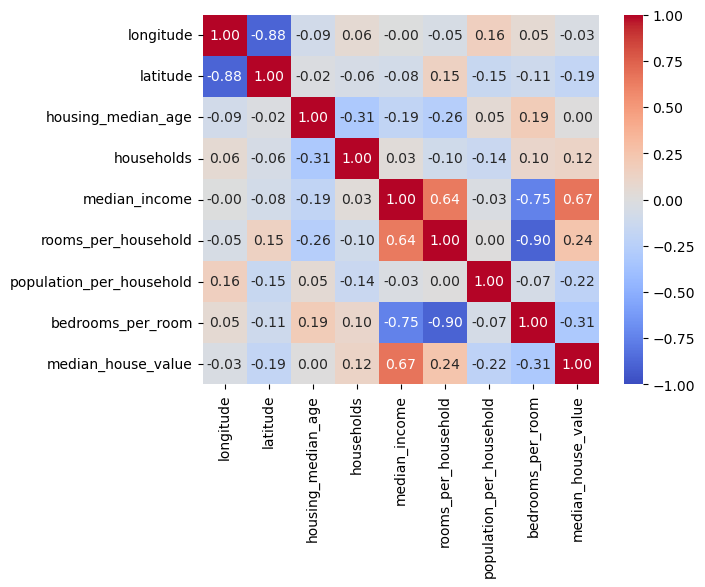

In [48]:
corr_matrix = data_train_new_features \
    .select_dtypes(include='number') \
    .corr(method='spearman')

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1,
    vmax=1,
)

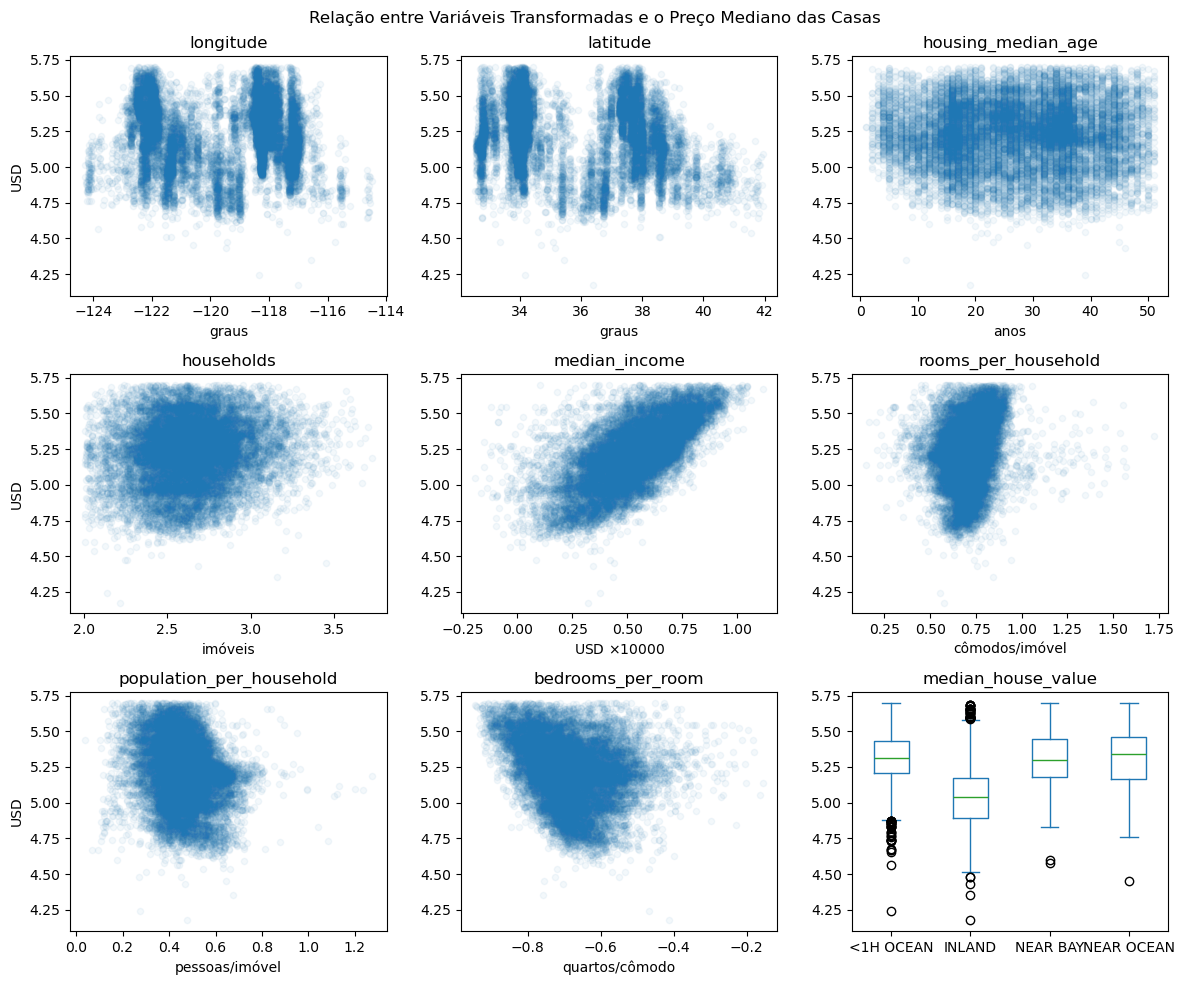

In [49]:
inches_per_column = 4
aspect_ratio = 1.2

n_rows = 3
n_cols = 3

width = n_cols * inches_per_column
height = n_rows * inches_per_column / aspect_ratio

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(width, height))
fig.suptitle(
    'Relação entre Variáveis Transformadas e o Preço Mediano das Casas')

for idx, (ax, feature) in enumerate(zip(axes.flatten(), num_features)):
    data_train_new_features.plot.scatter(
        x=feature,
        y=target,
        ax=ax,
        alpha=0.05,
    )
    if idx % n_cols == 0:
        y_label = measurement_units[target]
    else:
        y_label = None

    ax.set_title(feature)
    ax.set_xlabel(measurement_units[feature])
    ax.set_ylabel(y_label)

ax = axes.flatten()[-1]
data_train_new_features[['ocean_proximity', target]] \
    .plot \
    .box(by='ocean_proximity', ax=ax)

fig.tight_layout()

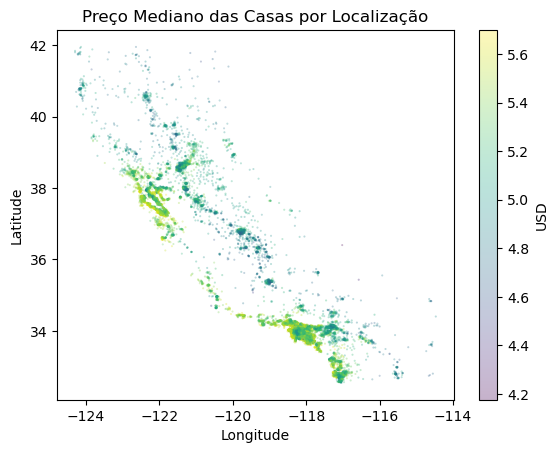

In [50]:
plt.scatter(
    data_train_new_features['longitude'],
    data_train_new_features['latitude'],
    c=data_train_new_features['median_house_value'],
    cmap='viridis',
    s=data_train_new_features['households'] / 10,
    alpha=0.3,
)
plt.colorbar(label=measurement_units[target])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Preço Mediano das Casas por Localização')
plt.show()

Quando o número de *features* é tão pequeno, podemos fazer uma análise de correlação mais detalhada. Neste caso, é importante tentar explicar o fenômeno observado com suas palavras, para ajudar no entendimento do *dataset*.

Algumas features apresentam forte correlação entre si:

- `rooms_per_household` versus `bedrooms_per_room`: alta correlação negativa. Parece legítimo: quanto menos cômodos (um imóvel pequeno), maior o número de quartos em relação a esse pequeno número de cômodos.

- `median_income` versus `bedrooms_per_room`: alta correlação negativa. Isso parece vir de modo indireto do fenômeno visto acima, pois quanto menor a renda, menor o imóvel, e (pela observação acima) consequentemente maior o número de quartos em relação ao número de cômodos.

- `median_income` versus `rooms_per_household`: moderada correlação positiva. Possivelmente vem do fato de que apenas pessoas de maior poder aquisitivo podem adquirir imóveis com grande número de cômodos. Mas esta correlação não é perfeita pois é possível ter pessoas de alto poder aquisitivo (em termos absolutos) adquirindo imóveis pequenos, quando estes se localizam em uma área muito valorizada.

Entre o target `median_house_value` e as features, ressalta-se que:

- `median_income` versus `median_house_value`: moderada correlação positiva - maior poder aquisitivo frequentemente (mas nem sempre, ver ressalva acima) resulta em aquisição de imóveis de maior valor.

- `house_median_age` versus `median_house_value`: surpreendentemente a correlação é praticamente nula, indicando que a idade mediana dos imóveis no bairro não impacta o valor mediano dos imóveis. Parece que temos de tudo: imóveis novos e caros, novos e baratos, antigos e caros (bairros nobres mais antigos), antigos e baratos.

Note que usamos a correlação de Spearman. Procure saber mais sobre esta correlação, e como ela se compara com a correlação usual, chamada correlação linear ou correlação de Pearson.

## Retomando a idéia da filtragem

Agora que fizemos toda a análise exploratória que queríamos fazer, vamos consolidar o conhecimento adquirido na forma de funções que realizam:

- Leitura dos dados brutos;
- Separação treino-teste;
- Pré-processamento **não-treinável**. Ou seja: transformações estáticas dos dados, que não requeiram treinamento. Isso se diferencia de pré-processamento **treinável**, que deverá fazer parte da pipeline **treinável** de pré-processamento e de modelagem.

Vamos escrever essas funções então. Para testar essas funções, vamos apagar tudo que já rodou neste notebook até aqui tambem.

In [51]:
%reset -f

As funções de leitura já estão feitas, vamos somente copiá-las aqui:

In [52]:
import tarfile
from pathlib import Path
from urllib import request

import numpy as np
import pandas as pd

In [53]:
def fetch_housing_data(data_dir: Path) -> None:
    '''Downloads the California Housing Prices dataset.

    Downloads the California Housing Prices dataset from Aurelien Geron's
    GitHub repository and saves it to the specified directory.

    Args:
        data_dir: The directory to which the dataset will be saved.

    Returns:
        None
    '''
    if not data_dir.exists():
        data_dir.mkdir(parents=True)

    # Fetch the housing data.
    HOUSING_URL = ('https://raw.githubusercontent.com/ageron/handson-ml2/'
                   'master/datasets/housing/housing.tgz')
    tgz_path = data_dir / 'housing.tgz'
    request.urlretrieve(HOUSING_URL, tgz_path)

    # Extract the housing data.
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=data_dir, filter='data')


def load_housing_data(data_dir: Path) -> pd.DataFrame:
    '''Loads the California Housing Prices dataset.

    Loads the California Housing Prices dataset from the specified directory.

    Args:
        data_dir: The directory from which the dataset will be loaded.

    Returns:
        A pandas DataFrame containing the California Housing Prices dataset.
    '''
    csv_path = data_dir / 'housing.csv'
    df = pd.read_csv(csv_path)
    return df


As funções de filtragem devem ser atualizadas com o que aprendemos na análise exploratória pós-separação treino-teste. Vamos incorporar a filtragem com o pré-processamento:

In [54]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    '''Pre-processes the California Housing Prices dataset.

    Pre-processes the California Housing Prices dataset by removing duplicates
    and filtering out invalid rows.

    Args:
        data: A pandas DataFrame containing the California Housing Prices dataset.

    Returns:
        A pandas DataFrame containing the pre-processed California Housing Prices dataset.
    '''
    # Remove duplicates.
    data = data.drop_duplicates()

    # Remove rows with spikes.
    valid_rows = ((data['median_income'] < 15) &
                  (data['housing_median_age'] < 52) &
                  (data['median_house_value'] < 500001))

    # Remove rows with ocean_proximity == 'ISLAND'.
    valid_rows &= data['ocean_proximity'] != 'ISLAND'

    data = data[valid_rows]

    # Compute new features.
    data['rooms_per_household'] = data['total_rooms'] / data['households']
    data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
    data['population_per_household'] = data['population'] / data['households']

    data = data.drop(columns=['total_rooms', 'total_bedrooms', 'population'])

    # Apply log transformation to selected features.
    scale_features = [
        'households',
        'median_income',
        'rooms_per_household',
        'population_per_household',
        'bedrooms_per_room',
        'median_house_value',
    ]

    for feature in scale_features:
        data[f'log_{feature}'] = data[feature].map(np.log10)

    data = data.drop(columns=scale_features)

    # Crop outliers.
    log_cut_point = 2.0
    valid_rows = data['log_households'] > log_cut_point
    data = data[valid_rows]

    return data

Agora vamos testar as funções:

In [55]:
DATA_DIR = Path.cwd().parents[5] / 'datasets' / 'housing'

print(f'{DATA_DIR=}')

DATA_DIR=PosixPath('/home/fjayres/dev/ml_labs/datasets/housing')


In [56]:
print(f'Deleting all files in {DATA_DIR}...')
for file in DATA_DIR.glob('*'):
    file.unlink()

Deleting all files in /home/fjayres/dev/ml_labs/datasets/housing...


In [57]:
print(f'Saving data to {DATA_DIR}')
fetch_housing_data(DATA_DIR)

Saving data to /home/fjayres/dev/ml_labs/datasets/housing


In [58]:
data = load_housing_data(DATA_DIR)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [60]:
preprocessed_data = preprocess_data(data)

In [61]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17929 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   longitude                     17929 non-null  float64
 1   latitude                      17929 non-null  float64
 2   housing_median_age            17929 non-null  float64
 3   ocean_proximity               17929 non-null  object 
 4   log_households                17929 non-null  float64
 5   log_median_income             17929 non-null  float64
 6   log_rooms_per_household       17929 non-null  float64
 7   log_population_per_household  17929 non-null  float64
 8   log_bedrooms_per_room         17742 non-null  float64
 9   log_median_house_value        17929 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [62]:
preprocessed_data.to_csv(DATA_DIR / 'preprocessed_data.csv', index=False)

Parece ok.

Idealmente, devemos fazer o seguinte:

- Código na forma de funções deverá ir para *módulos* Python (arquivos `.py`). 
    - Conforme o projeto cresce, é melhor criar múltiplos módulos e organizá-los em um *pacote* Python (um diretório cheio de módulos, sub-pacotes, e obrigatoriamente um arquivo nomeado `__init__.py`). Este pacote deve estar dentro de um diretório `src`, subdiretório com nome do pacote.
    - Para ter acesso ao pacote a partir de outros arquivos Python (notebooks, scripts, etc) é importante ter um arquivo `pyproject.toml` descrevendo características do projeto Python em desenvolvimento.
- Código exploratório na forma de `notebooks` Python vão em um diretório `notebooks`.
- Scripts Python (arquivos `.py` que são executados diretamente) vão em um diretório `scripts`.
- Testes (e.g. testes unitários) do pacote Python vão para um diretório `tests`.

Vamos então criar essa estrutura na nossa próxima tarefa! Até breve!